In [1]:
import ROOT
import numpy as np
from matplotlib import pyplot as plt
import array
import os, sys
from multiprocessing import Pool
from matplotlib import rcParams
import time
%jsroot on
rcParams['axes.titlepad'] = 20 

rate, efficiency = np.loadtxt("MVA-points.txt", unpack = True)
ROOT.gInterpreter.ProcessLine(".L LoopLineShape.cpp")
ROOT.gInterpreter.ProcessLine(".L Optimization.cpp")

Welcome to JupyROOT 6.28/06


0

In [2]:
rate, efficiency = np.loadtxt("MVA-points.txt", unpack = True)
print(rate)

[3.14812747e-04 6.41062525e-04 9.47605806e-04 1.26425999e-03
 1.58205262e-03 1.89290382e-03 2.22171796e-03 2.52544101e-03
 2.85235198e-03 3.16025232e-03 3.47902849e-03 3.80550062e-03
 4.38152133e-03 5.14263035e-03 6.81728696e-03 7.84918758e-03
 1.14547918e-02 1.37935877e-02 1.60862644e-02 1.93706967e-02
 2.37783944e-02 3.19281403e-02 4.09909339e-02 5.98205368e-02
 8.50909042e-02 1.29044685e-01 1.94453019e-01 2.98700882e-01
 5.52520452e-01 8.76359398e-01 1.10369530e+00 1.97719257e+00
 4.34796493e+00]


## GENERATE THE DATA

In [ ]:
# DATA GENERATION
simulationCPP = "LoopLineShape"
mvaScan = "\"true\""
ConfFile = "\"ToyConfiguration.txt\""
Nfiles = "1000"

def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

def generate(i):
    CosmicRate = str(rate[i])
    Efficiency = str(efficiency[i])
    folder = "mva_" + str(i)
    if not os.path.exists(folder):	# Check if the folder exist
        os.makedirs(folder)	# Create the folder
    code = simulationCPP + "(" + Nfiles + ",\"" + folder + "/\"," + mvaScan + "," + CosmicRate + "," + Efficiency + "," + ConfFile + ")"
    print("running: ", code)
    ROOT.LoopLineShape(int(Nfiles),folder + "/","true", rate[i], efficiency[i],"ToyConfiguration.txt")
    os.popen("cp ToyConfiguration.txt " + folder + "/"  + "ToyConfiguration.txt")	

# Paraller generation of the data
njob = 7
indexes = range(0,len(rate))
for i in range(0, int(len(rate)/njob)):
    #Create list of point to be generated
    start = i*njob
    stop = (i+1)*njob
    index = np.asarray(indexes[start:stop])
    print("Generating MVA points: ", index)
    if __name__ == "__main__":
        # Generate Files
        with Pool(processes = njob, maxtasksperchild = 1) as pool:
            pool.map(generate, index)
    # Create list of last points to be generated
    if (i == (int(len(rate)/njob) - 1) and (len(rate))%njob != 0):
        start = (i+1)*njob
        stop = start + len(rate)%njob
        index = np.asarray(indexes[start:stop])
        print("generating last points: " , index)
        # Generate last points
        if __name__ == "__main__":
            with Pool(processes = njob, maxtasksperchild = 1) as pool:
                pool.map(generate, index)
for i in range(0,len(rate)):
    folder = "mva_" + str(i)
    replace_line(folder + "/ToyConfiguration.txt", 17, "CosmicRate = %f\n" % (rate[i]))
    replace_line(folder + "/ToyConfiguration.txt", 18, "Efficiency = %f\n" % (efficiency[i]))

## ANALYZE THE DATA

### ROC parameter optimization

In [3]:
# import itertools package
from itertools import product # package for the combinations

#Parameters of the algorithms
# initialize lists
Nfilter = [3,4,5,6,7,8]
Nsigma = [ 3/2, 2, 5/2, 3, 7/2, 4]
fraction = [ 15/100 , 20/100 , 25/100, 30/100, 35/100, 40/100]
Nthr = [2,3,4,5,6,7]
Nthr1 = [3,4,5,6,7,8]
Nthr2 = [3,4,5,6,7,8]
Ntrial = 1000

folder = "scanMvaData/mva_"
for i in range(0, len(rate)):
    folder2 = "Plot/mva_" + str(i)
    if not os.path.exists(folder2):	# Check if the folder exist
        os.makedirs(folder2)	# Create the folder

combinations = list(product(Nfilter, Nsigma))     # Combination of Nfilter and Nsigma
print("list of combination: ", type(combinations))
combinations = list(map(list, combinations))      # Convert to list

combthrs = list(product(Nthr1, Nthr2)) # Combination of Threshold 1 and threshold 2
print("list of combination: ", type(combthrs))
combthrs = list(map(list, combthrs))   # Convert to list

for i,item in enumerate(combinations): # Add other parameter
    index = i%len(fraction) 
    combinations[i].append(fraction[index])  # add fraction values to list of parameters
    index = i%len(Nthr)
    combinations[i].append(Nthr[index])      # add treshold for single threshold parameter
    combinations[i].append(combthrs[i][0])   # add thr1 and thr2 to list of combinations
    combinations[i].append(combthrs[i][1])   # thr2

print("combinations: [Nfilter, Nsigma, fraction, Nthr, Nthr1, Nthr2]")
print("Number of Combinations: ", len(combinations))
print("Combinations: ", combinations[:6])

index = range(0,len(rate)) # index of the MVA scan
#index = index[::2]


# Create matrix to store the values of the optimization
# first index is the combination, second index MVA point
# standard deviation
ROC_stdSum = np.empty( (0,len(index)) ,float) 
ROC_stdSign = np.empty( (0,len(index)) ,float) 
ROC_stdCf  = np.empty( (0,len(index)) ,float)
ROC_stdThr = np.empty( (0,len(index)) ,float)
ROC_stdVeto= np.empty( (0,len(index)) ,float)
ROC_stdRev = np.empty( (0,len(index)) ,float)
# bias
ROC_biasSum = np.empty( (0,len(index)) ,float)
ROC_biasSign = np.empty( (0,len(index)) ,float)
ROC_biasCf  = np.empty( (0,len(index)) ,float)
ROC_biasThr = np.empty( (0,len(index)) ,float)
ROC_biasVeto= np.empty( (0,len(index)) ,float)
ROC_biasRev = np.empty( (0,len(index)) ,float)

list of combination:  <class 'list'>
list of combination:  <class 'list'>
combinations: [Nfilter, Nsigma, fraction, Nthr, Nthr1, Nthr2]
Number of Combinations:  36
Combinations:  [[3, 1.5, 0.15, 2, 3, 3], [3, 2, 0.2, 3, 3, 4], [3, 2.5, 0.25, 4, 3, 5], [3, 3, 0.3, 5, 3, 6], [3, 3.5, 0.35, 6, 3, 7], [3, 4, 0.4, 7, 3, 8]]


In [4]:
# analysis task to be runned in parallel
def task(i):
    values = ROOT.Optimization(folder + str(i) + "/", folder +  str(i) + "/ToyConfiguration.txt", Ntrial, Nfilter, fraction, Nsigma, Nthr, Nthr1, Nthr2 ,rate[i], "Plot/mva_" + str(i) + "/")
    npResult = np.asarray(values)
    return npResult

for j,item in enumerate(combinations): # For each combination, perform the MVA scan
    # Update the parameters
    Nfilter = item[0]
    Nsigma  = item[1]
    fraction = item[2]
    Nthr = item[3]
    Nthr1 = item[4]
    Nthr2 = item[5]
    
    #Initialize the array
    # all the algorithms are with background subtraction
    
    # Sum Neighbors 
    bias_sum = np.array([])
    devStandard_sum = np.array([])
    onset_sum = np.array([])
    onset2_sum = np.array([])
    # Significance 
    bias_sign = np.array([])
    devStandard_sign = np.array([])
    onset_sign = np.array([])
    onset2_sign = np.array([])
    # Reversed 2017
    bias_rev = np.array([])
    devStandard_rev = np.array([])
    onset_rev = np.array([])
    onset2_rev = np.array([])
    # forward 2017
    bias_fw = np.array([])
    devStandard_fw = np.array([])
    onset_fw = np.array([])
    onset2_fw = np.array([])
    # Constant Fraction
    bias_cf = np.array([])
    devStandard_cf = np.array([])
    onset_cf = np.array([])
    onset2_cf = np.array([])
    # Threshold
    bias_thr = np.array([])
    devStandard_thr = np.array([])
    onset_thr = np.array([])
    onset2_thr = np.array([])
    
    start = time.time() # start time measurement
    # go parallel!
    if __name__ == "__main__":
        # create the process pool
        with Pool(processes = 11, maxtasksperchild = 1) as pool: # number of core to be used in the parallel analysis, max process for each core always equal to 1 to avoid memory leak
            for results in pool.map(task, index):
                # append th results to the arrays
                bias_thr =  np.append(bias_thr, results[0]);   devStandard_thr = np.append(devStandard_thr, results[1])
                bias_fw  =  np.append(bias_fw, results[2]);    devStandard_fw  = np.append(devStandard_fw, results[3])
                bias_rev =  np.append (bias_rev, results[4]); devStandard_rev = np.append(devStandard_rev, results[5])
                bias_cf  =  np.append (bias_cf, results[6]);  devStandard_cf  = np.append(devStandard_cf, results[7])
                bias_sum =  np.append(bias_sum, results[8]);  devStandard_sum = np.append(devStandard_sum, results[9])
                bias_sign = np.append(bias_sign,results[10]); devStandard_sign = np.append(devStandard_sign, results[11])
            print("combination: %d° " %j, item)
            # save the  results in the ROC matrices for the later analysis
            # standard deviation of (onset2 - onset1) measured - MCtruch
            ROC_stdSum  = np.append(ROC_stdSum, [devStandard_sum], axis = 0)
            ROC_stdSign  = np.append(ROC_stdSign, [devStandard_sign], axis = 0)
            ROC_stdCf   = np.append(ROC_stdCf,  [devStandard_cf] , axis = 0)
            ROC_stdThr  = np.append(ROC_stdThr, [devStandard_thr], axis = 0)
            ROC_stdVeto = np.append(ROC_stdVeto,[devStandard_fw] , axis = 0)
            ROC_stdRev  = np.append(ROC_stdRev, [devStandard_rev], axis = 0)
            # bias of (onset2 - onset1) measured - MCtruth
            ROC_biasSum  = np.append(ROC_biasSum, [bias_sum], axis = 0)
            ROC_biasSign  = np.append(ROC_biasSign, [bias_sign], axis = 0)
            ROC_biasCf   = np.append(ROC_biasCf,  [bias_cf] , axis = 0)
            ROC_biasThr  = np.append(ROC_biasThr, [bias_thr], axis = 0)
            ROC_biasVeto = np.append(ROC_biasVeto,[bias_fw] , axis = 0)
            ROC_biasRev  = np.append(ROC_biasRev, [bias_rev], axis = 0)
    end = time.time()
    print("    Time for one configuration: %.2f seconds" % (end - start), " time needed: %.2f minutes" % ((end - start)*(len(combinations) - j)/60))

print("ROC SCAN DONE")
print("GOODCOFFE")

combination: 0°  [3, 1.5, 0.15, 2, 3, 3]
    Time for one configuration: 1188.44 seconds  time needed: 713.07 minutes
combination: 1°  [3, 2, 0.2, 3, 3, 4]
    Time for one configuration: 1185.20 seconds  time needed: 691.37 minutes
combination: 2°  [3, 2.5, 0.25, 4, 3, 5]
    Time for one configuration: 1187.26 seconds  time needed: 672.78 minutes
combination: 3°  [3, 3, 0.3, 5, 3, 6]
    Time for one configuration: 1188.96 seconds  time needed: 653.93 minutes
combination: 4°  [3, 3.5, 0.35, 6, 3, 7]
    Time for one configuration: 1191.23 seconds  time needed: 635.32 minutes
combination: 5°  [3, 4, 0.4, 7, 3, 8]
    Time for one configuration: 1179.22 seconds  time needed: 609.26 minutes
combination: 6°  [4, 1.5, 0.15, 2, 4, 3]
    Time for one configuration: 1184.95 seconds  time needed: 592.47 minutes
combination: 7°  [4, 2, 0.2, 3, 4, 4]
    Time for one configuration: 1181.77 seconds  time needed: 571.19 minutes
combination: 8°  [4, 2.5, 0.25, 4, 4, 5]
    Time for one configurat

## BUILD A COST FUNCTION

In [5]:
# Cost functions
ROC_cost_cf = np.sqrt(ROC_stdCf**2 + ROC_biasCf**2)
ROC_cost_thr = np.sqrt(ROC_stdThr**2 + ROC_biasThr**2)
ROC_cost_veto = np.sqrt(ROC_stdVeto**2 + ROC_biasVeto**2) 
ROC_cost_rev = np.sqrt(ROC_stdRev**2 + ROC_biasRev**2)
ROC_cost_sum = np.sqrt(ROC_stdSum**2 + ROC_biasSum**2)
ROC_cost_sign = np.sqrt(ROC_stdSign**2 + ROC_biasSign**2)

## Find minimum configuration

constant fraction:  (30, 20)
combination: [8, 1.5, 0.15, 2, 8, 3]
t student:  (28, 23)
combination: [7, 3.5, 0.35, 6, 7, 7]
t student with modifications:  (16, 23)
combination: [5, 3.5, 0.35, 6, 5, 7]
Reversed:  (32, 22)
combination: [8, 2.5, 0.25, 4, 8, 5]
Threshold:  (5, 21)
combination: [3, 4, 0.4, 7, 3, 8]
Const Fraction: Best combination for each points


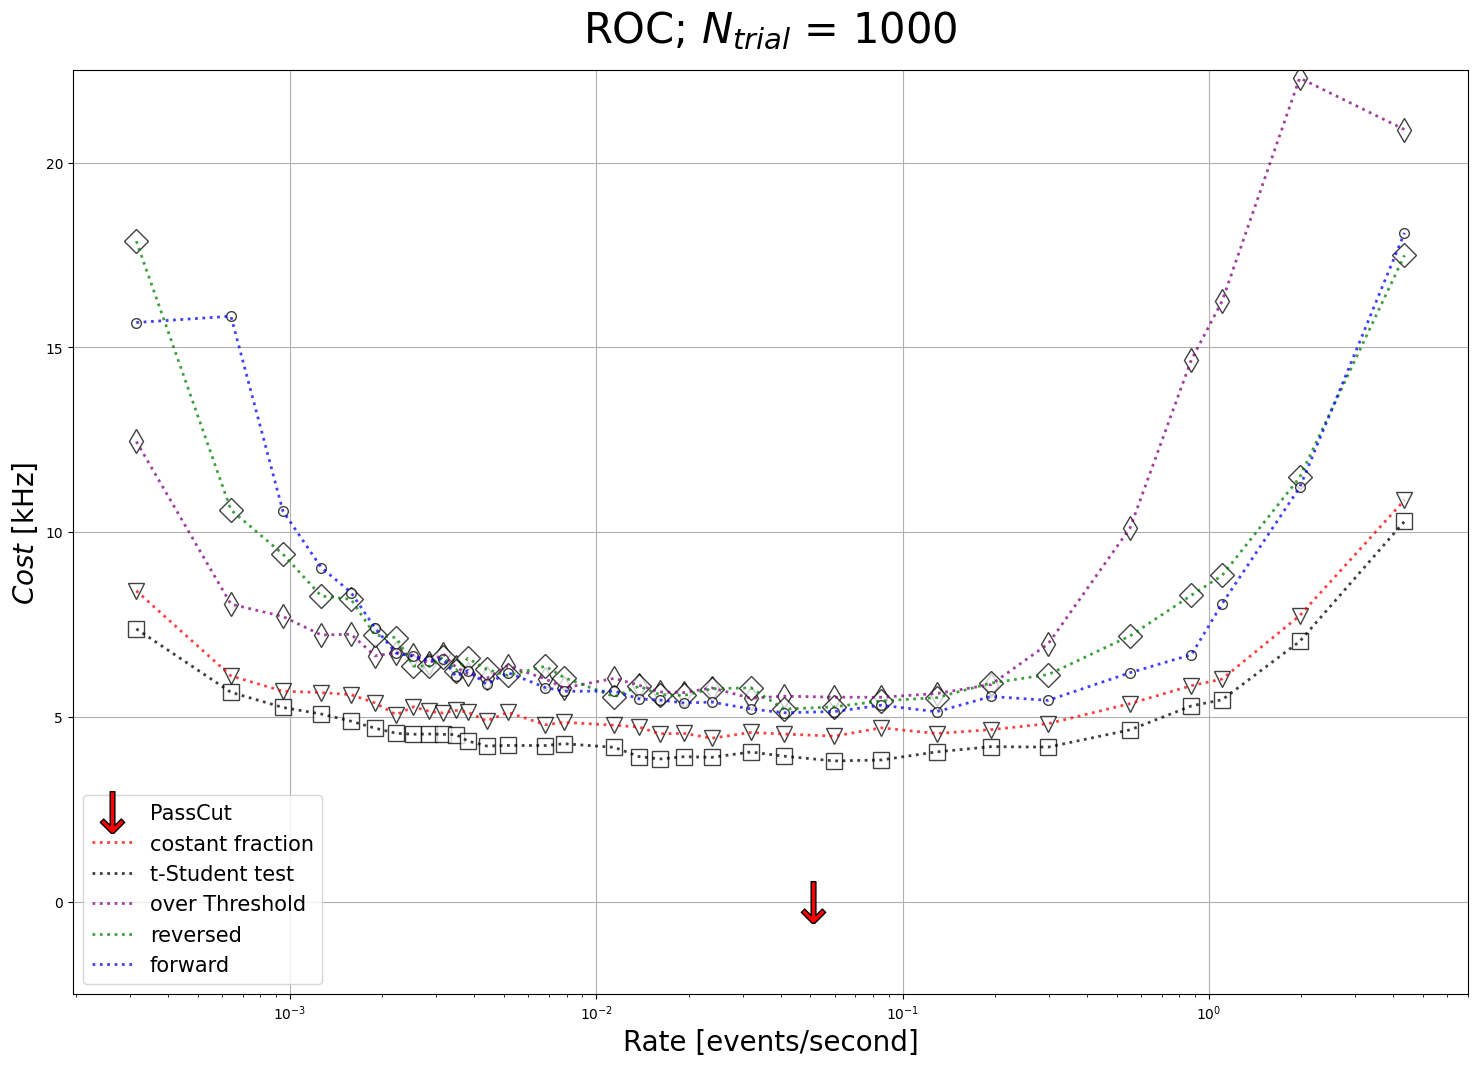

In [9]:
import matplotlib._color_data as mcd # package for colors

# list of colors for each combinations of parameters
overlap = {name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS}
overlap = list(overlap)
overlap = sorted(overlap, reverse=True)

# Find best configuration which minimize the cost
ind = np.unravel_index(np.argmin(ROC_cost_cf, axis = None), ROC_cost_cf.shape)
print("constant fraction: ", ind)
print("combination:", combinations[ind[0]])

ind = np.unravel_index(np.argmin(ROC_cost_sum, axis = None), ROC_cost_sum.shape)
print("t student: ", ind)
print("combination:", combinations[ind[0]])

ind = np.unravel_index(np.argmin(ROC_cost_sign, axis = None), ROC_cost_sign.shape)
print("t student with modifications: ", ind)
print("combination:", combinations[ind[0]])

ind = np.unravel_index(np.argmin(ROC_cost_rev, axis = None), ROC_cost_rev.shape)
print("Reversed: ", ind)
print("combination:", combinations[ind[0]])

ind = np.unravel_index(np.argmin(ROC_cost_thr, axis = None), ROC_cost_thr.shape)
print("Threshold: ", ind)
print("combination:", combinations[ind[0]])



# Find the best configuration of each algorithm with respect to each MVA points
print("Const Fraction: Best combination for each points")
# CONSTANT FRACTION
minimaInd_cf = np.argmin(ROC_cost_cf, axis = 0)
best_cf = np.zeros(len(rate))
# T STUDENT TEST
minimaInd_sum = np.argmin(ROC_cost_sum, axis = 0)
best_sum = np.zeros(len(rate))
# SIGNIFICANCE
minimaInd_sign = np.argmin(ROC_cost_sign, axis = 0)
best_sign = np.zeros(len(rate))
# THRESHOLD
minimaInd_thr = np.argmin(ROC_cost_thr, axis = 0)
best_thr = np.zeros(len(rate))
# REVERSED
minimaInd_rev = np.argmin(ROC_cost_rev, axis = 0)
best_rev = np.zeros(len(rate))
# FORWARD
minimaInd_veto = np.argmin(ROC_cost_veto, axis = 0)
best_veto = np.zeros(len(rate))

# Plot of the best configuration for each point
plt.figure(0,figsize = (18,12))

for i,item in enumerate(rate): # Loop on each MVA point
    # constant fraction
    index = minimaInd_cf[i]
    best_cf[i] = ROC_cost_cf[index][i]
    plt.errorbar(item, best_cf[i], linestyle = '', markersize = 12, marker = "v", color = "white",markeredgecolor='black', alpha = 0.75)
    #print("MVA point %d" % i, "combination: ",  index)
    # t-student
    index = minimaInd_sum[i]
    best_sum[i] = ROC_cost_sum[index][i]
    plt.errorbar(item, best_sum[i], linestyle = '',marker = "s", markersize = 12, color = "white", markeredgecolor='black', alpha = 0.75)
    # threshold
    index = minimaInd_thr[i]
    best_thr[i] = ROC_cost_thr[index][i]
    plt.errorbar(item, best_thr[i], linestyle = '',marker = "d", markersize = 12, color = "white", markeredgecolor='black', alpha = 0.75)
    # reversed
    index = minimaInd_rev[i]
    best_rev[i] = ROC_cost_rev[index][i]
    plt.errorbar(item, best_rev[i], linestyle = '',marker = "D", markersize =12, color = "white", markeredgecolor='black', alpha = 0.75)
    # forward
    index = minimaInd_veto[i]
    best_veto[i] = ROC_cost_veto[index][i]
    plt.errorbar(item, best_veto[i], linestyle = '',marker = ".", markersize = 14, color = "white", markeredgecolor='black', alpha = 0.75)

# PASSCUT



plt.title("ROC; " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
plt.ylim(-2.5,22.5)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$\downarrow$', markersize = 30, markeredgecolor='black', label = "PassCut", alpha = 1)
plt.errorbar(rate, best_cf , linestyle = 'dotted', color = "red", label = "costant fraction", linewidth = 2 ,alpha = 0.75)
plt.errorbar(rate, best_sum, linestyle = 'dotted', color = "black", label = r"t-Student test",linewidth = 2 , alpha = 0.75)
plt.errorbar(rate, best_thr, linestyle = 'dotted', color = "purple", label = "over Threshold", linewidth = 2 ,alpha = 0.75)
plt.errorbar(rate, best_rev, linestyle = 'dotted', color = "green", label = "reversed", linewidth = 2 ,alpha = 0.75)
plt.errorbar(rate, best_veto, linestyle = 'dotted', color = "blue", label = "forward", linewidth = 2 ,alpha = 0.75)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_best_values2.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_best_values2.pdf", format = "pdf")

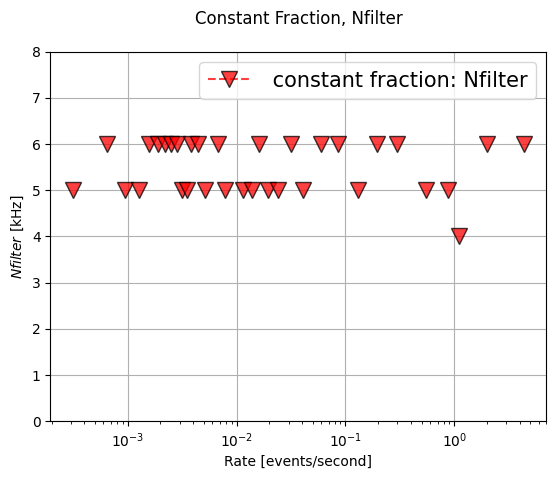

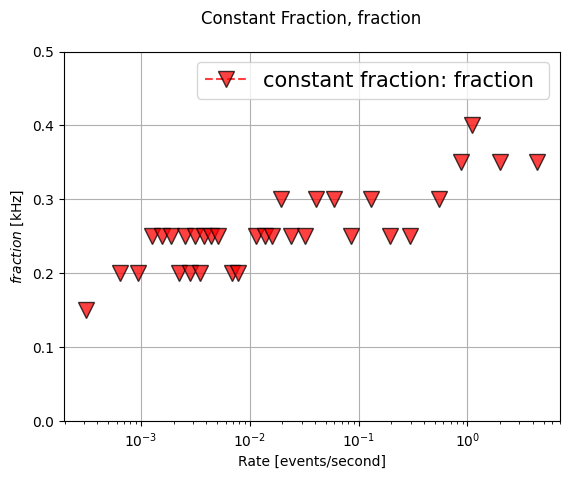

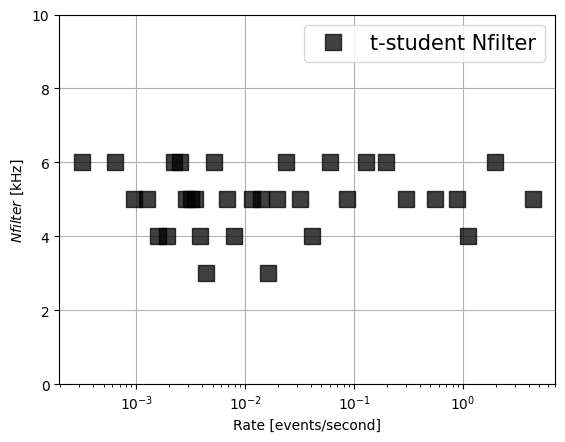

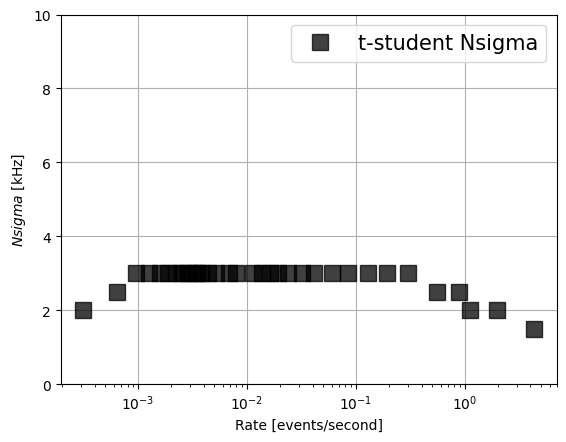

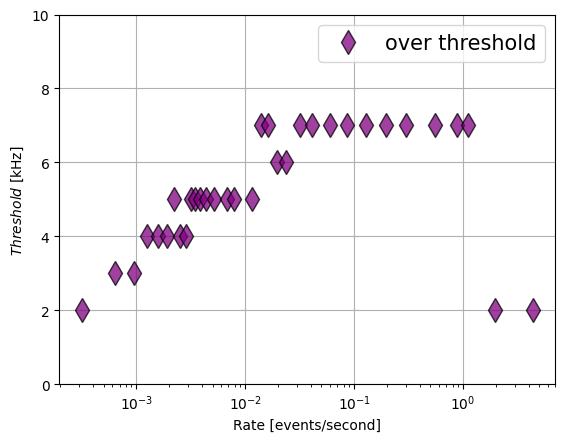

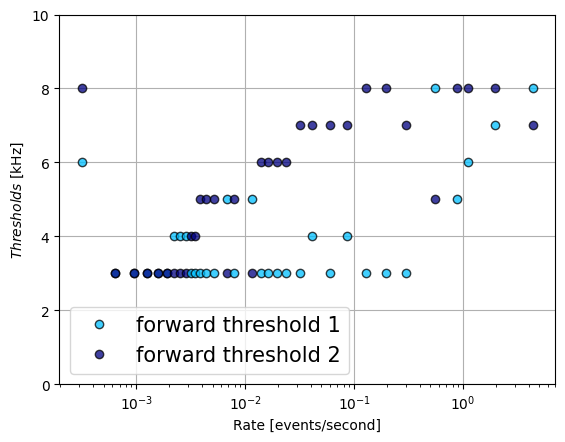

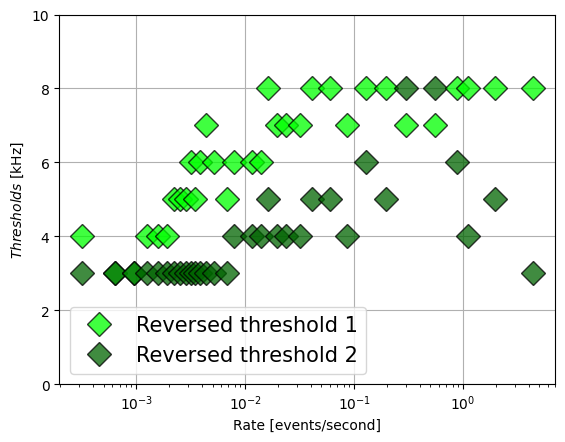

In [18]:
# Plots of the Best Parameters versus MVA points
# constant fraction, Nfilter
plt.figure(1)
plt.title("Constant Fraction, Nfilter")
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Nfilter$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,8)

for i in range(0,len(rate)):
    index    = minimaInd_cf[i]
    Nfilter  = combinations[index][0]
    fraction = combinations[index][2]
    if(i == 0):
        plt.errorbar(rate[i], Nfilter, linestyle = '--', markersize = 12, color = "red", marker = "v",markeredgecolor='black', label = " constant fraction: Nfilter", alpha = 0.75)
    else:
        plt.errorbar(rate[i], Nfilter, linestyle = '--', markersize = 12, color = "red", marker = "v",markeredgecolor='black', alpha = 0.75)
plt.legend(fontsize = 15)

# Constant Fraction, fraction
plt.figure(2)
plt.title("Constant Fraction, fraction")
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$fraction$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,0.5)

for i in range(0,len(rate)):
    index = minimaInd_cf[i]
    Nfilter = combinations[index][0]
    fraction = combinations[index][2]
    if(i == 0):
        plt.errorbar(rate[i], fraction, linestyle = '--', markersize = 12, marker = "v", color = "red" ,markeredgecolor='black', label = "constant fraction: fraction " , alpha = 0.75)
    else:
        plt.errorbar(rate[i], fraction, linestyle = '--', markersize = 12, marker = "v", color = "red" ,markeredgecolor='black', alpha = 0.75)
plt.legend(fontsize = 15)

plt.figure(14312336, )
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Nfilter$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,10)
for i in range(0,len(rate)):
    #t-student
    index = minimaInd_sum[i]
    Nfilter = combinations[index][0]
    Nsigma = combinations[index][1]
    #print("MVA point %d" % i, "combination: ",  index)
    if(i == 0):
        plt.errorbar(rate[i], Nfilter, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', label = "t-student Nfilter", alpha = 0.75)
        #plt.errorbar(rate[i], Nsigma, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', label = "t-student Nsigma" ,alpha = 0.75)
    else:
        plt.errorbar(rate[i], Nfilter, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', alpha = 0.75)
        #plt.errorbar(rate[i], Nsigma, linestyle = '',marker = "s", markersize = 12, color = "black",markeredgecolor='black', alpha = 0.75)
plt.legend(fontsize = 15)

plt.figure(143123, )
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Nsigma$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,10)
for i in range(0,len(rate)):
    #t-student
    index = minimaInd_sum[i]
    Nfilter = combinations[index][0]
    Nsigma = combinations[index][1]
    #print("MVA point %d" % i, "combination: ",  index)
    if(i == 0):
        #plt.errorbar(rate[i], Nfilter, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', label = "t-student Nfilter", alpha = 0.75)
        plt.errorbar(rate[i], Nsigma, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', label = "t-student Nsigma" ,alpha = 0.75)
    else:
        #plt.errorbar(rate[i], Nfilter, linestyle = '',marker = "s", markersize = 12, color = "black", markeredgecolor='black', alpha = 0.75)
        plt.errorbar(rate[i], Nsigma, linestyle = '',marker = "s", markersize = 12, color = "black",markeredgecolor='black', alpha = 0.75)
plt.legend(fontsize = 15)

plt.figure(14312335, )
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Threshold$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,10)
for i in range(0,len(rate)):
    # threshold
    index = minimaInd_thr[i]
    thr_thr = combinations[index][3]
    #print("MVA point %d" % i, "combination: ",  index)
    if(i == 0):
        plt.errorbar(rate[i], thr_thr, linestyle = '',marker = "d", markersize = 12, color = "purple", label = "over threshold" ,markeredgecolor='black', alpha = 0.75)
    else:
        plt.errorbar(rate[i], thr_thr, linestyle = '',marker = "d", markersize = 12, color = "purple" ,markeredgecolor='black', alpha = 0.75)

plt.legend(fontsize = 15)
plt.figure(254234, )
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Thresholds$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,10)
for i in range(0, len(rate)):
    # forward
    index = minimaInd_veto[i]
    veto_thr1 = combinations[index][4]
    veto_thr2 = combinations[index][5]
    #print("MVA point %d" % i, "combination: ",  index)
    if(i == 0):
        plt.errorbar(rate[i], veto_thr1, linestyle = '',marker = ".", markersize =12, color = "deepskyblue", label = "forward threshold 1" ,markeredgecolor='black', alpha = 0.75)
        plt.errorbar(rate[i], veto_thr2, linestyle = '',marker = ".", markersize =12, color = "navy", label = "forward threshold 2" ,markeredgecolor='black', alpha = 0.75)
    else:
        plt.errorbar(rate[i], veto_thr1, linestyle = '',marker = ".", markersize =12, color = "deepskyblue", markeredgecolor='black', alpha = 0.75)
        plt.errorbar(rate[i], veto_thr2, linestyle = '',marker = ".", markersize =12, color = "navy", markeredgecolor='black', alpha = 0.75)

plt.legend(fontsize = 15)

plt.figure(25424, )
plt.xlabel("Rate [events/second]", fontsize = 10)
plt.ylabel(r"$Thresholds$ [kHz]", fontsize = 10)
plt.xscale("log")
plt.grid()
plt.ylim(0,10)
for i in range(0, len(rate)):
    # reversed
    index = minimaInd_rev[i]
    veto_thr1 = combinations[index][4]
    veto_thr2 = combinations[index][5]
    if(i == 0):
        plt.errorbar(rate[i], veto_thr1, linestyle = '',marker = "D", markersize =12, color = "lime", label = "Reversed threshold 1" ,markeredgecolor='black', alpha = 0.75)
        plt.errorbar(rate[i], veto_thr2, linestyle = '',marker = "D", markersize =12, color = "darkgreen", label = "Reversed threshold 2" ,markeredgecolor='black', alpha = 0.75)
    else:
        plt.errorbar(rate[i], veto_thr1, linestyle = '',marker = "D", markersize =12, color = "lime", markeredgecolor='black', alpha = 0.75)
        plt.errorbar(rate[i], veto_thr2, linestyle = '',marker = "D", markersize =12, color = "darkgreen", markeredgecolor='black', alpha = 0.75)
    #print("MVA point %d" % i, "combination: ",  index)
plt.legend(fontsize = 15)

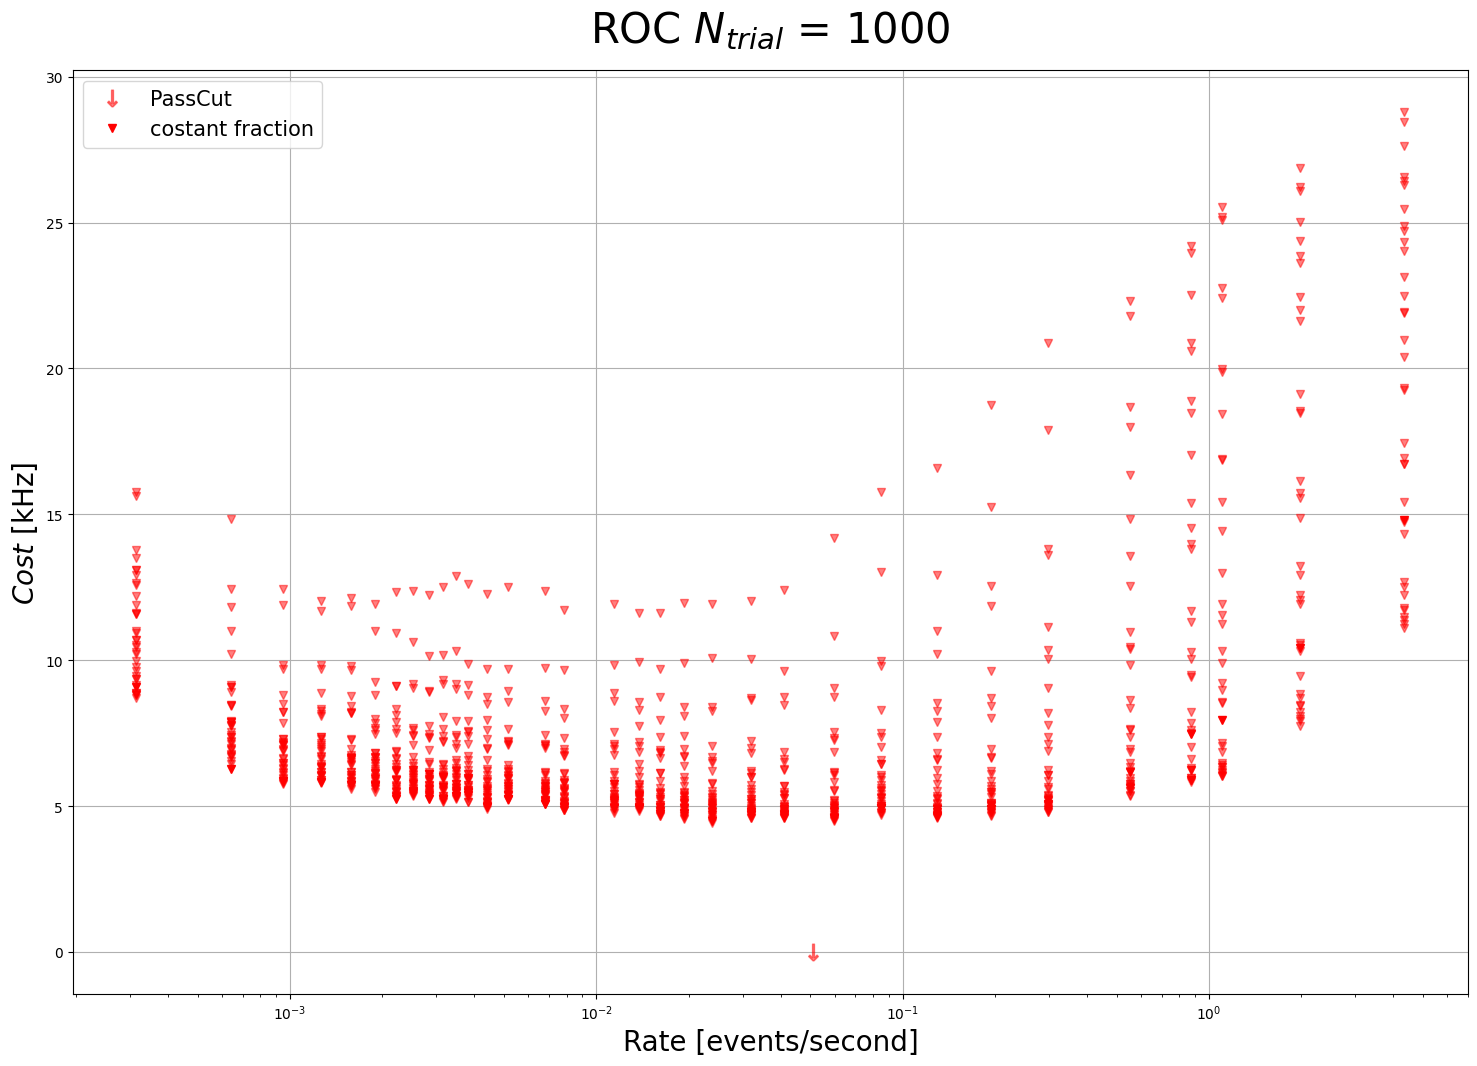

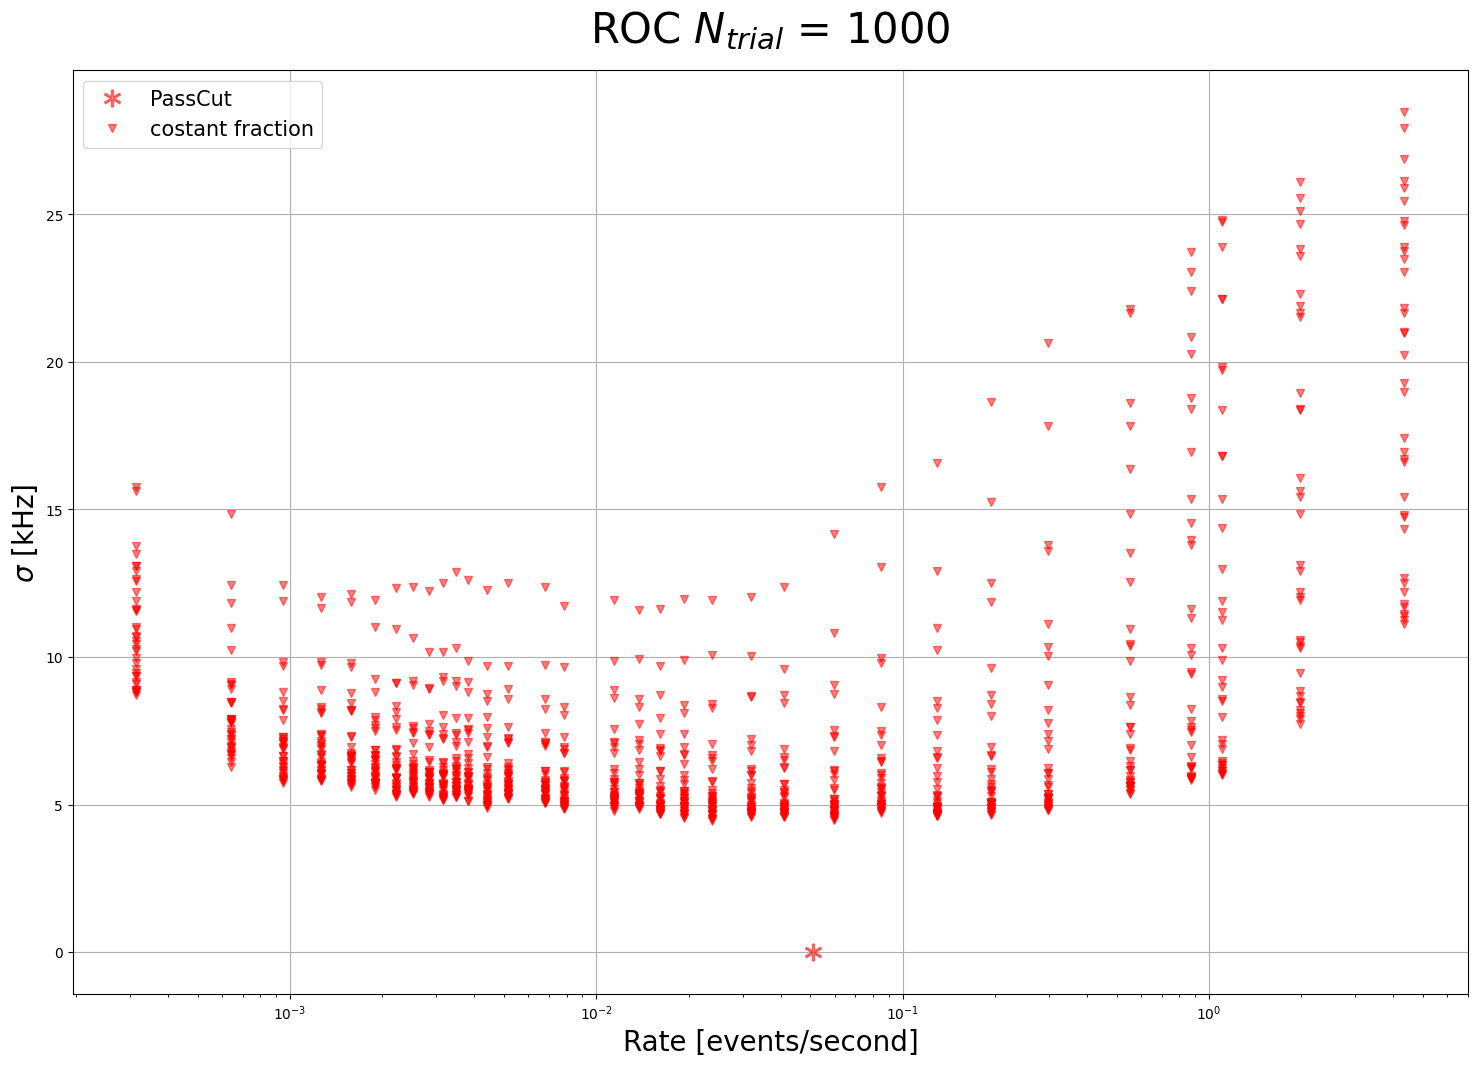

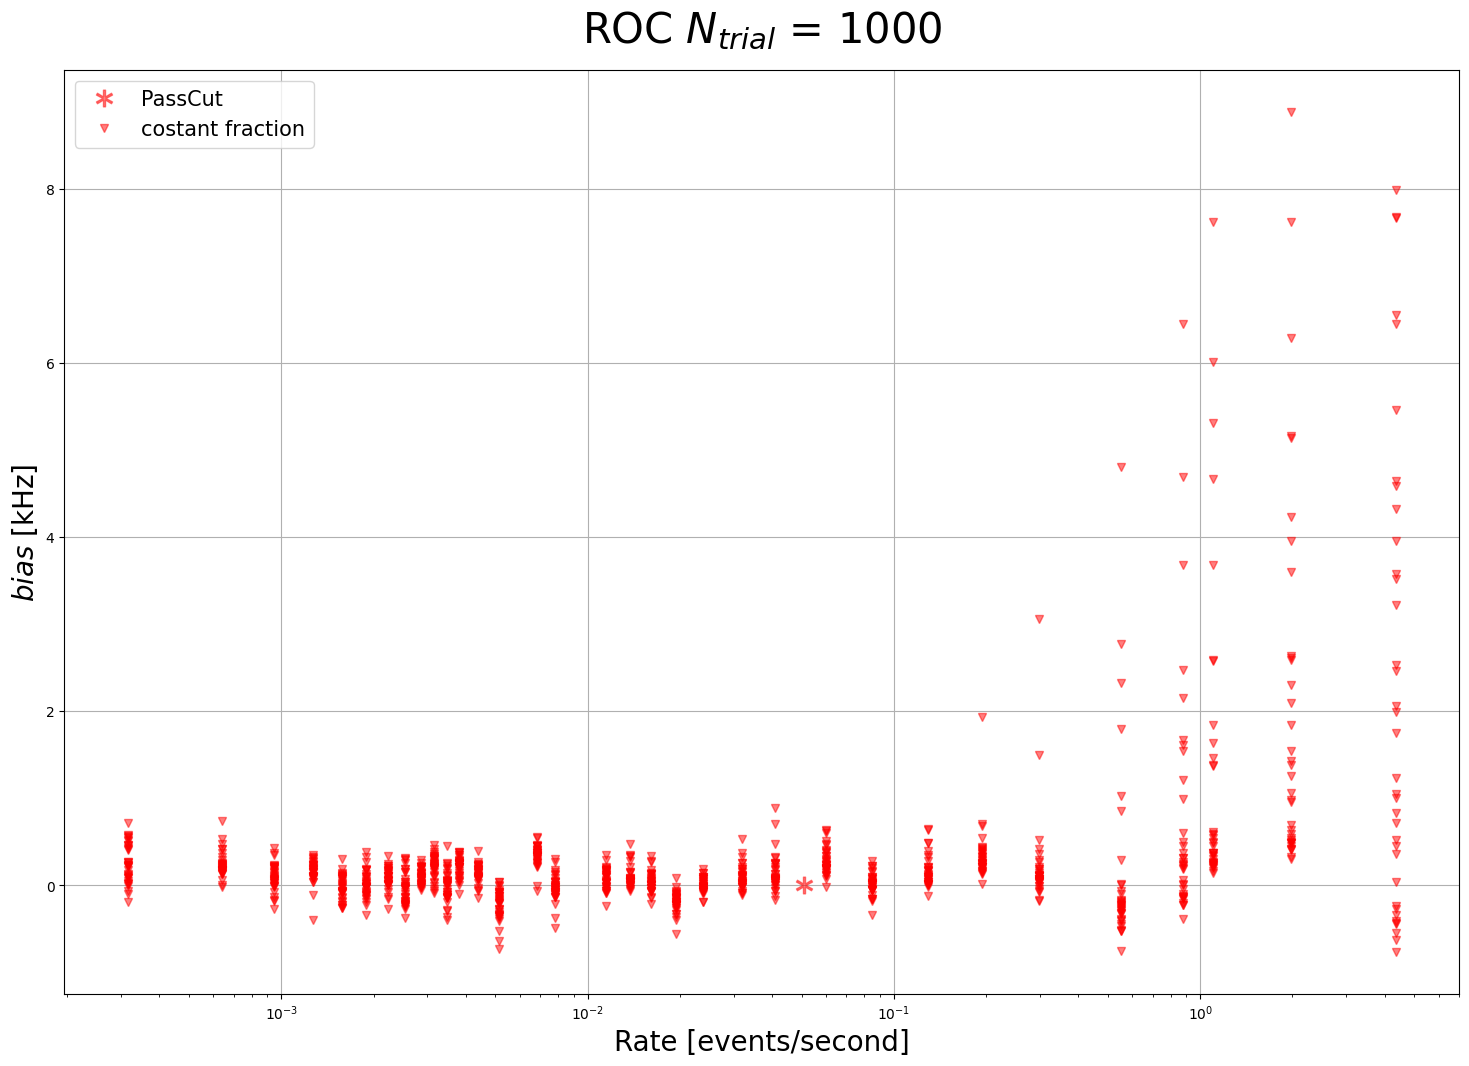

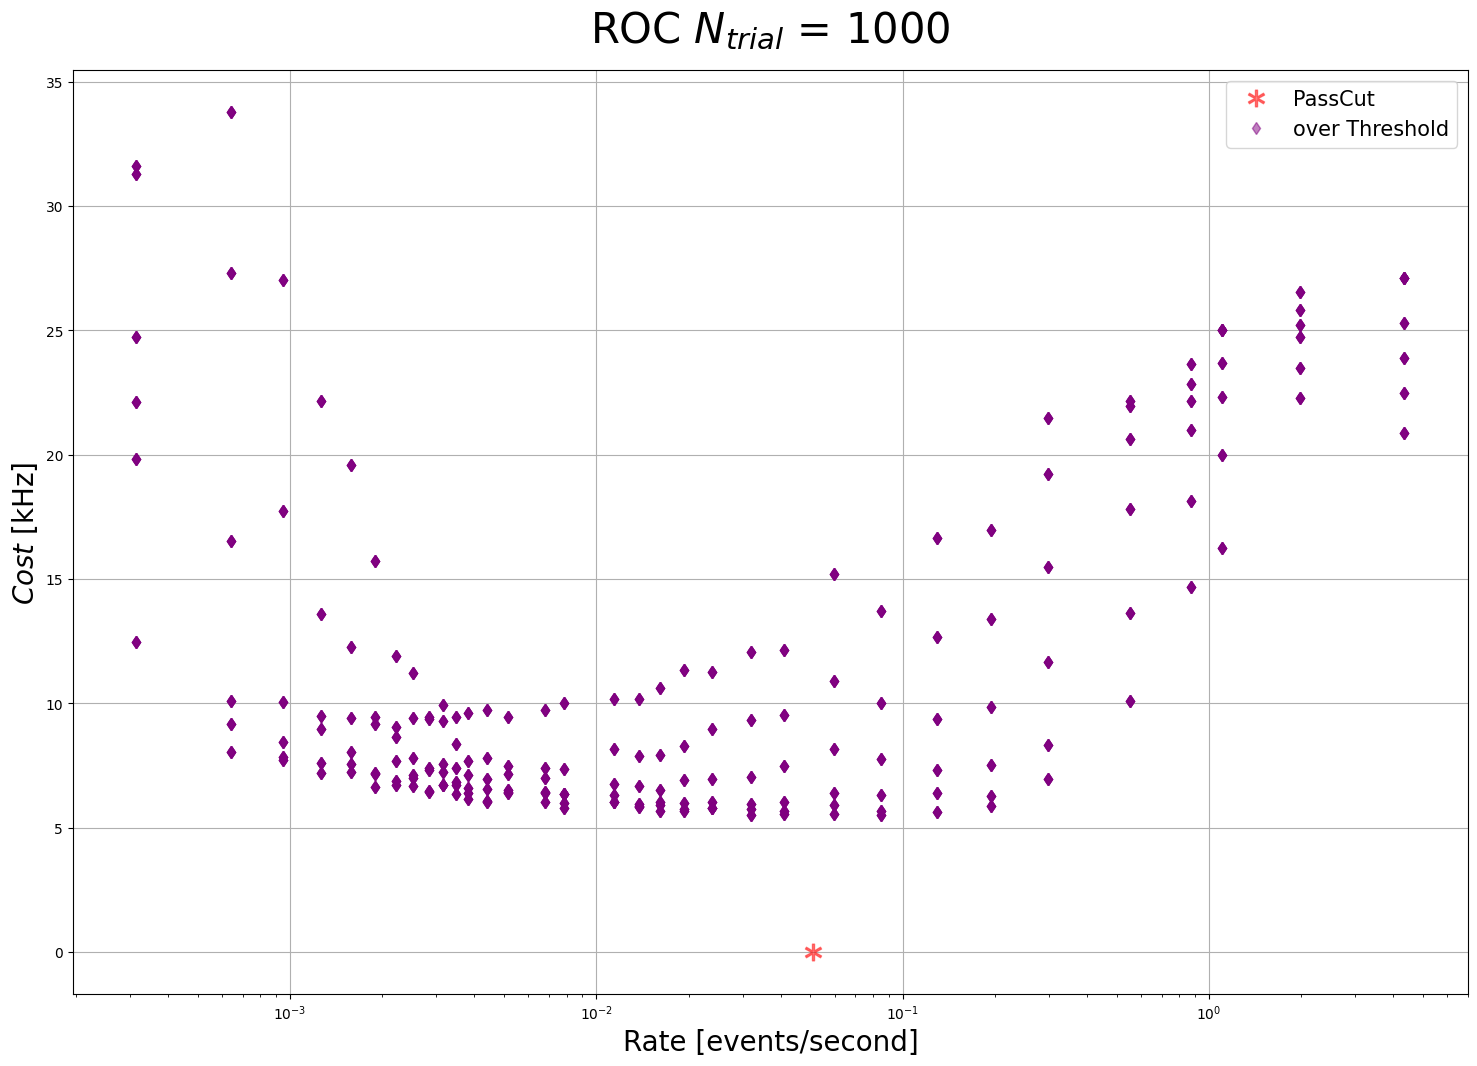

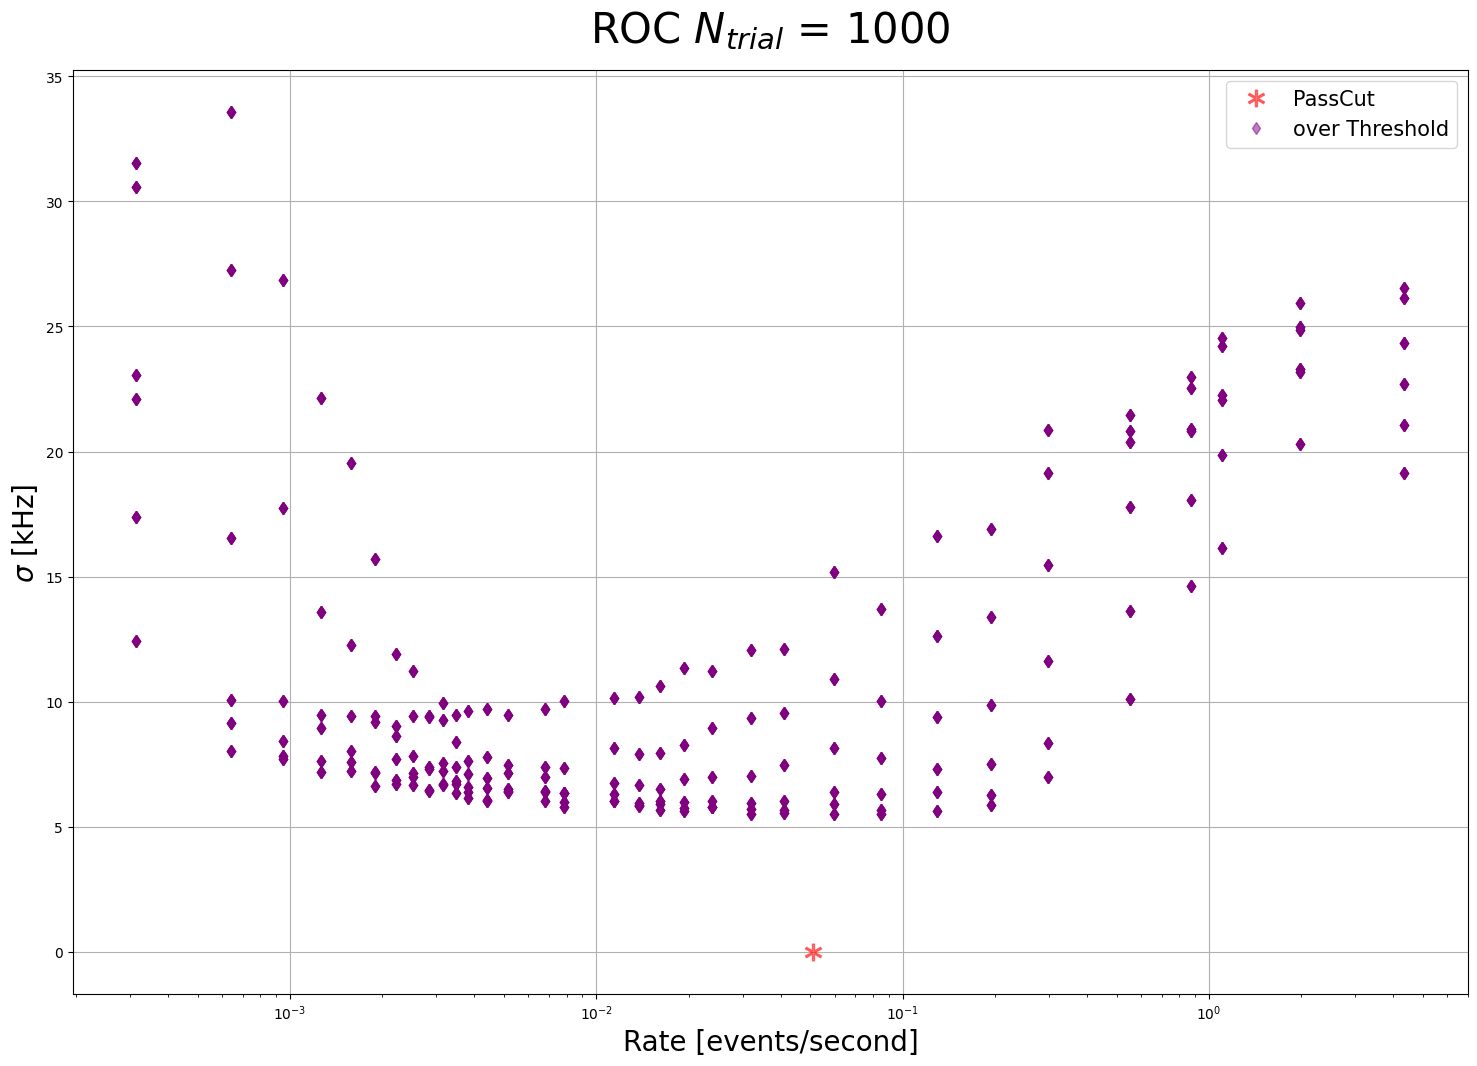

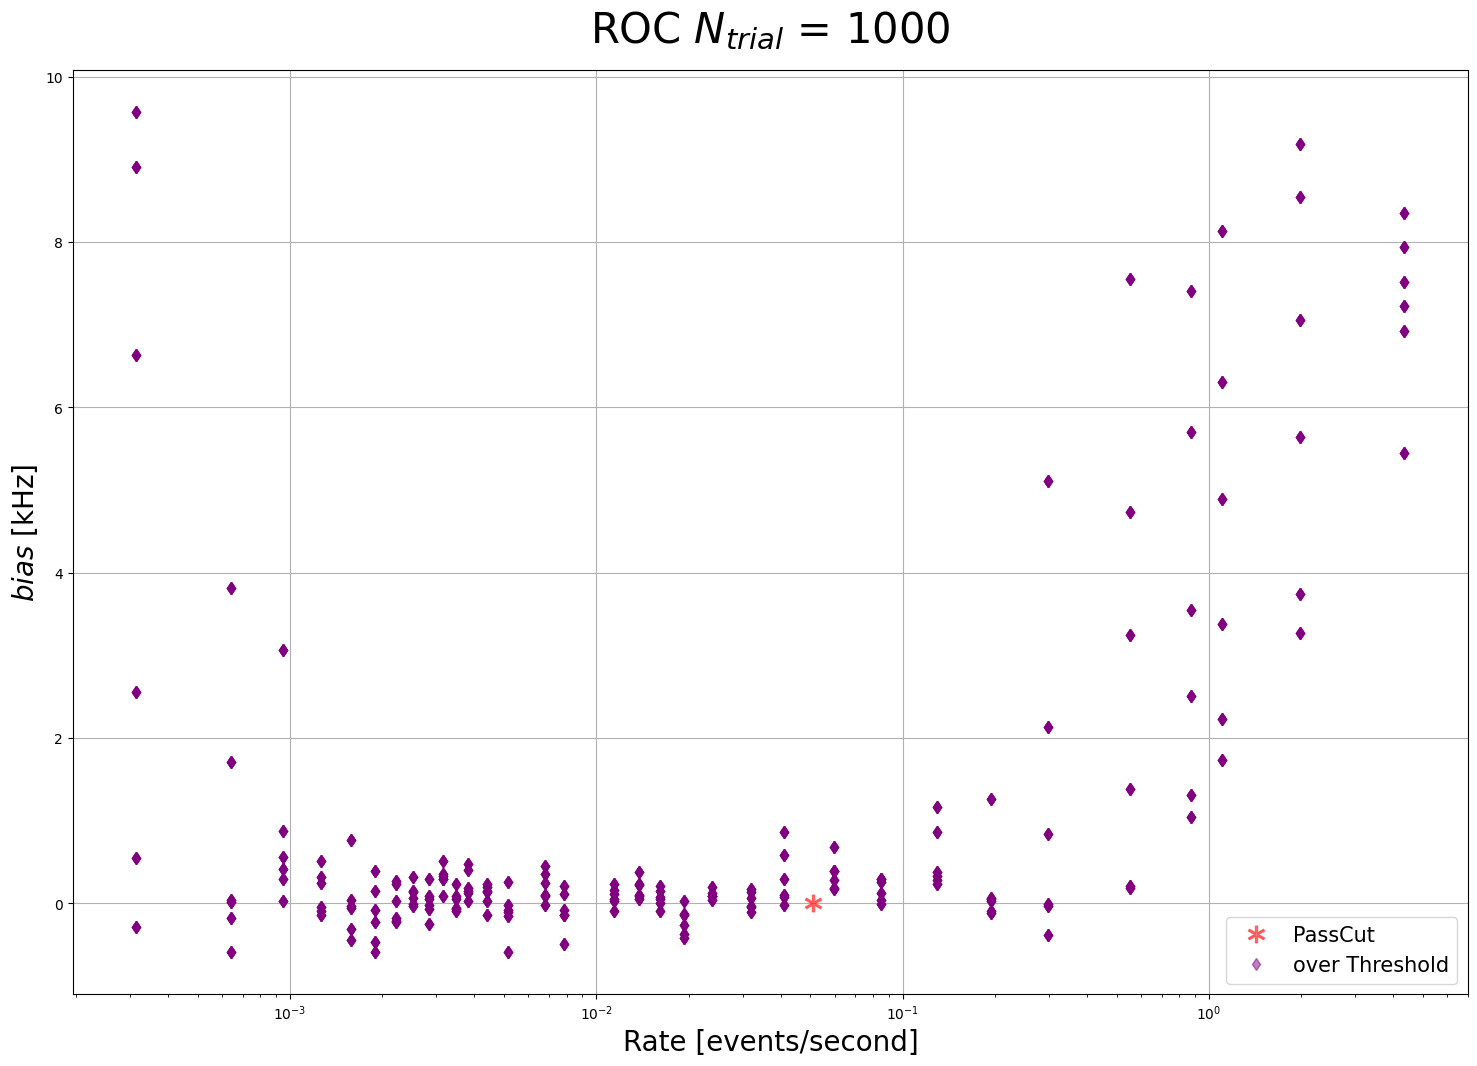

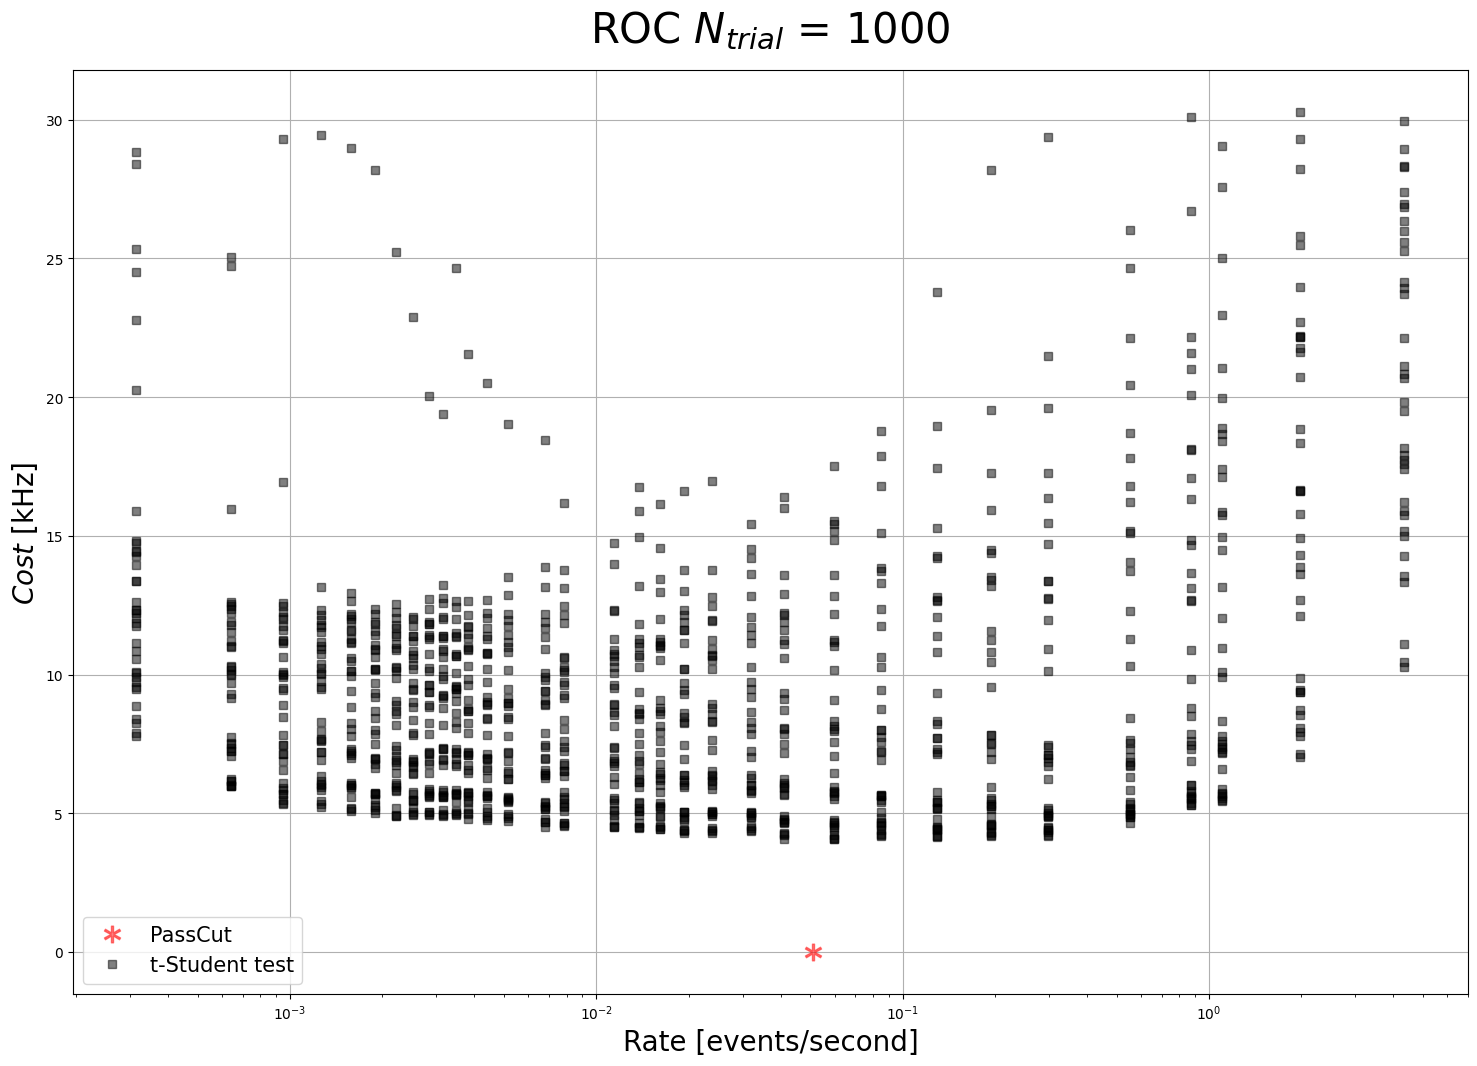

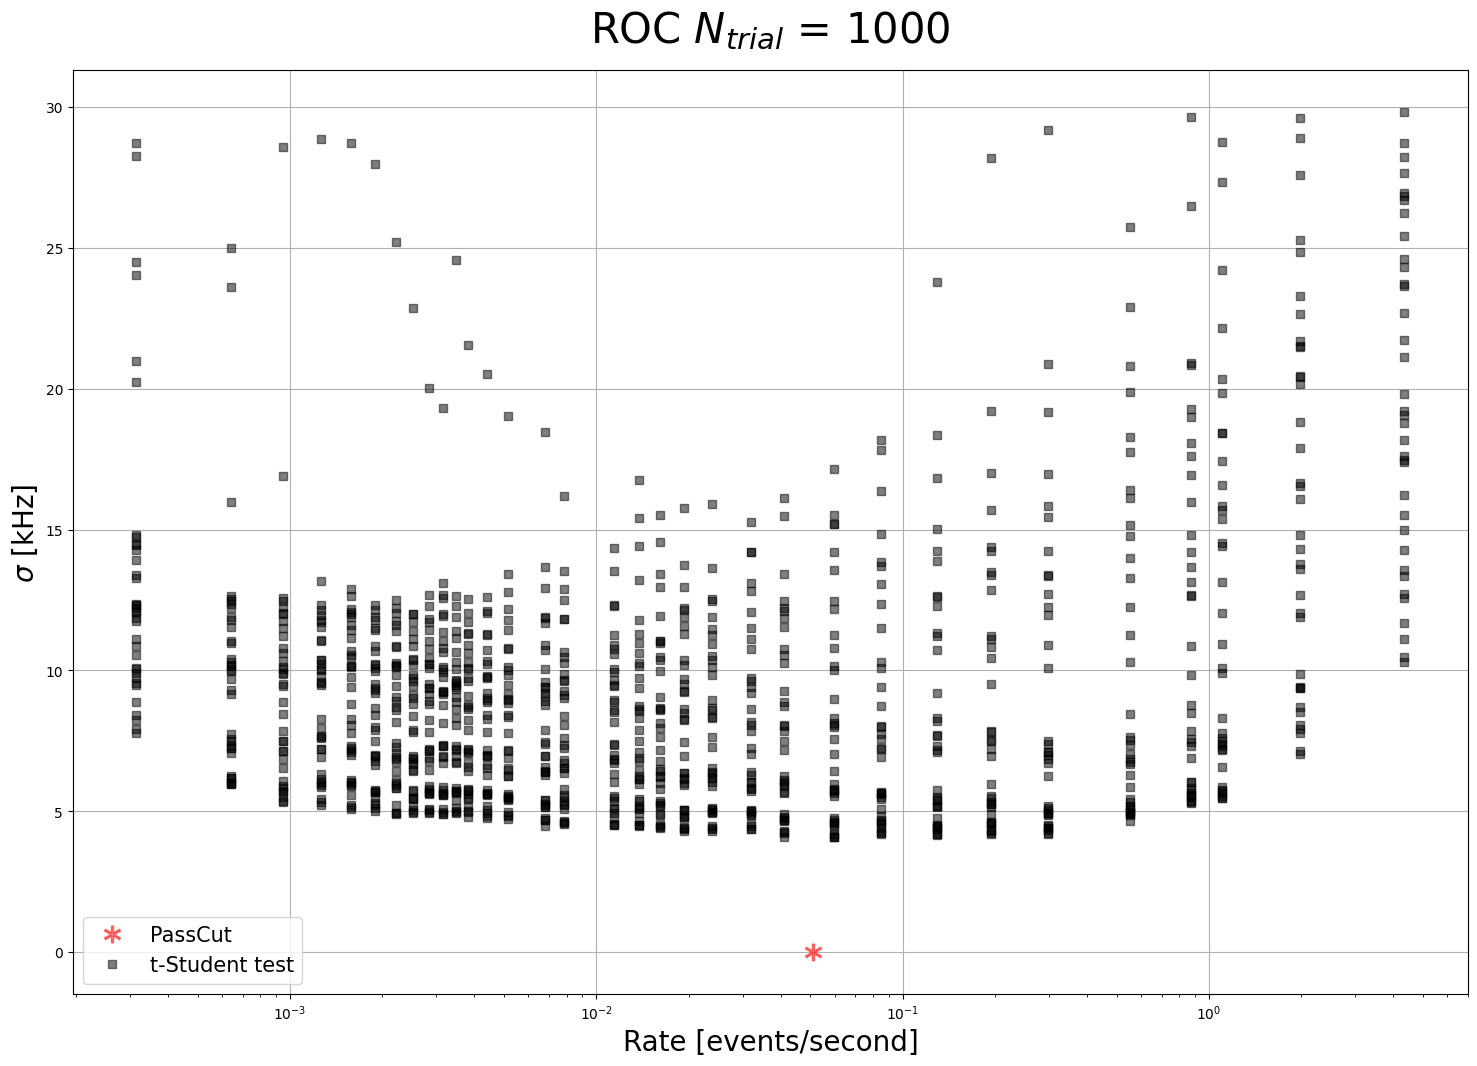

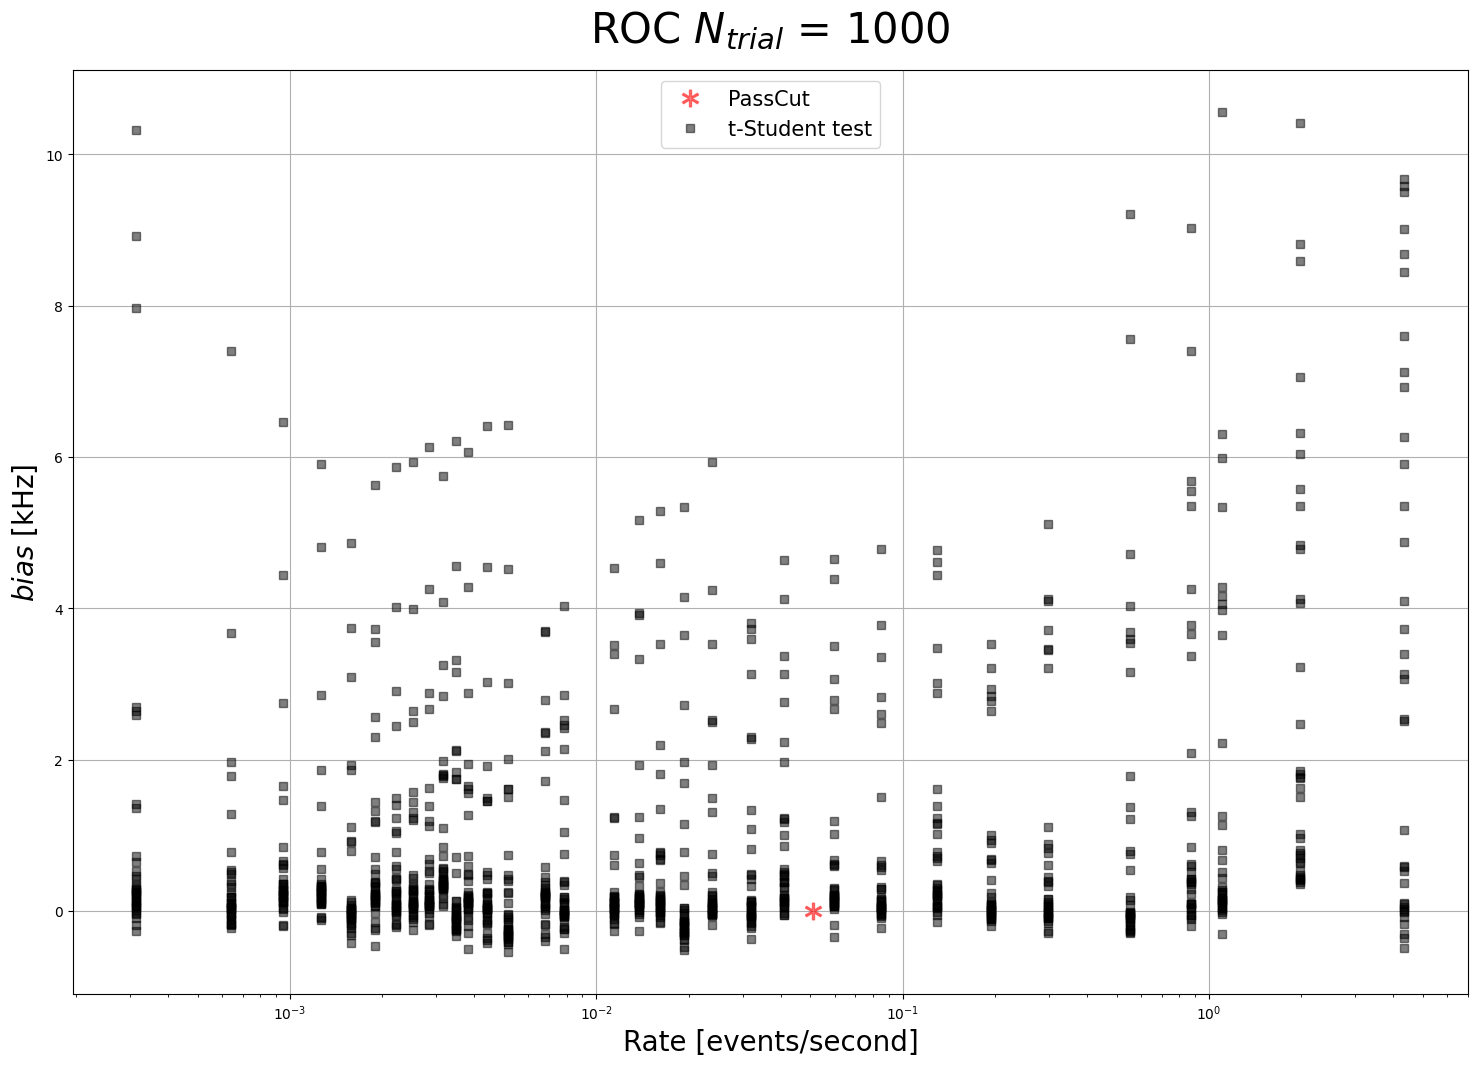

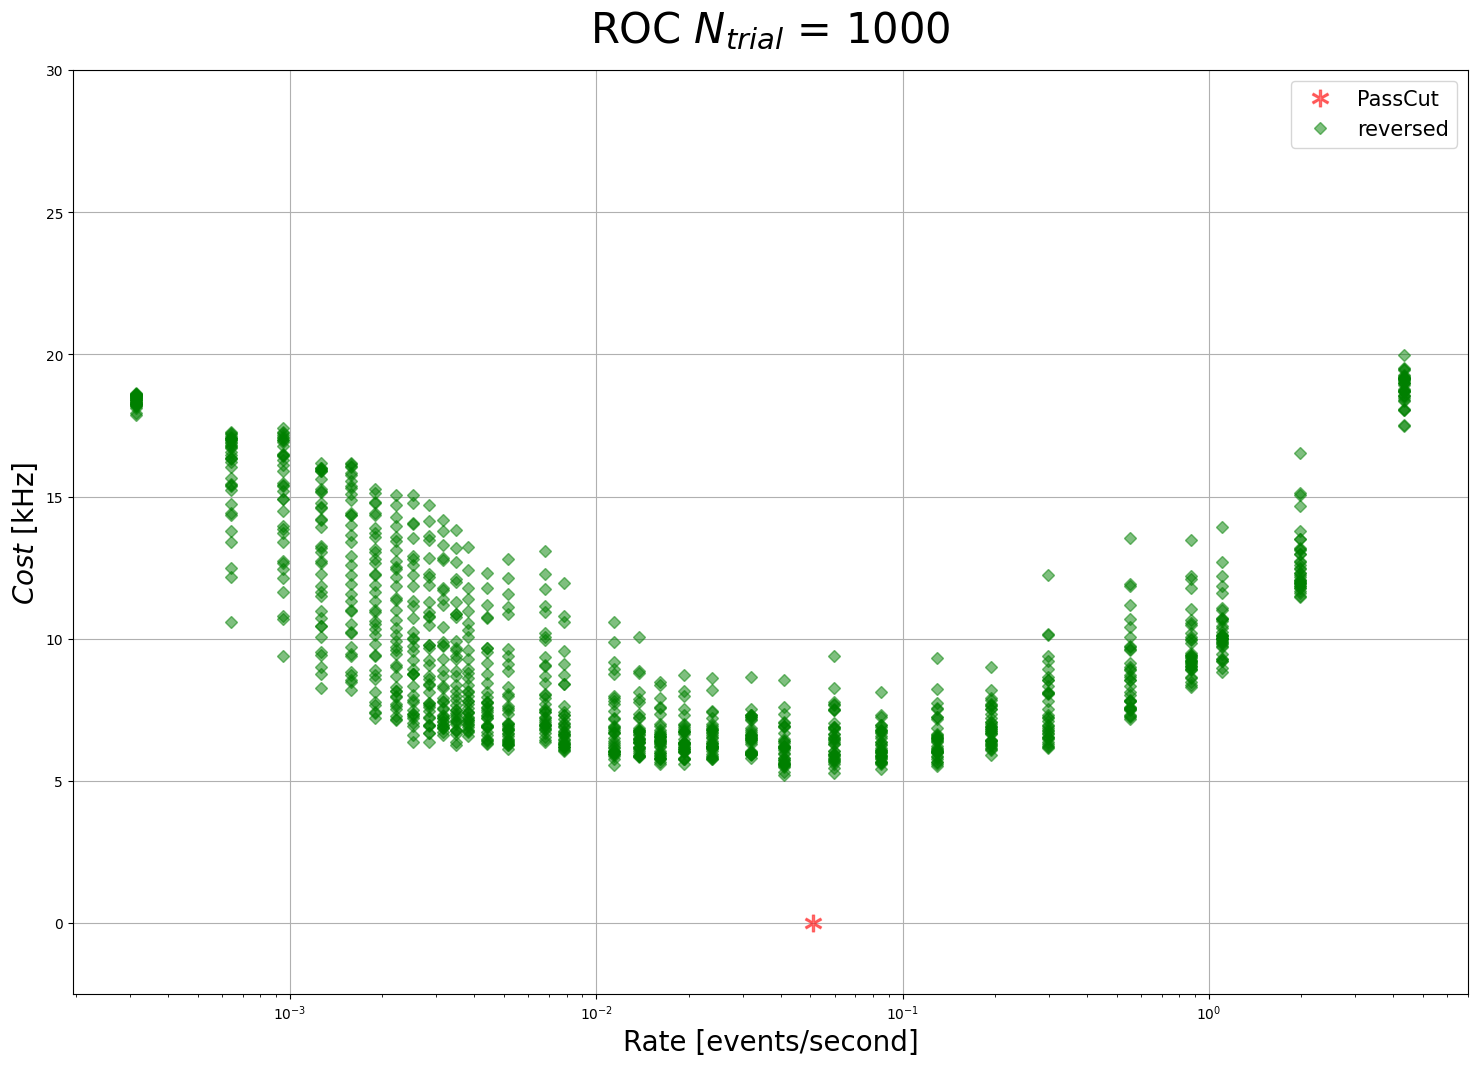

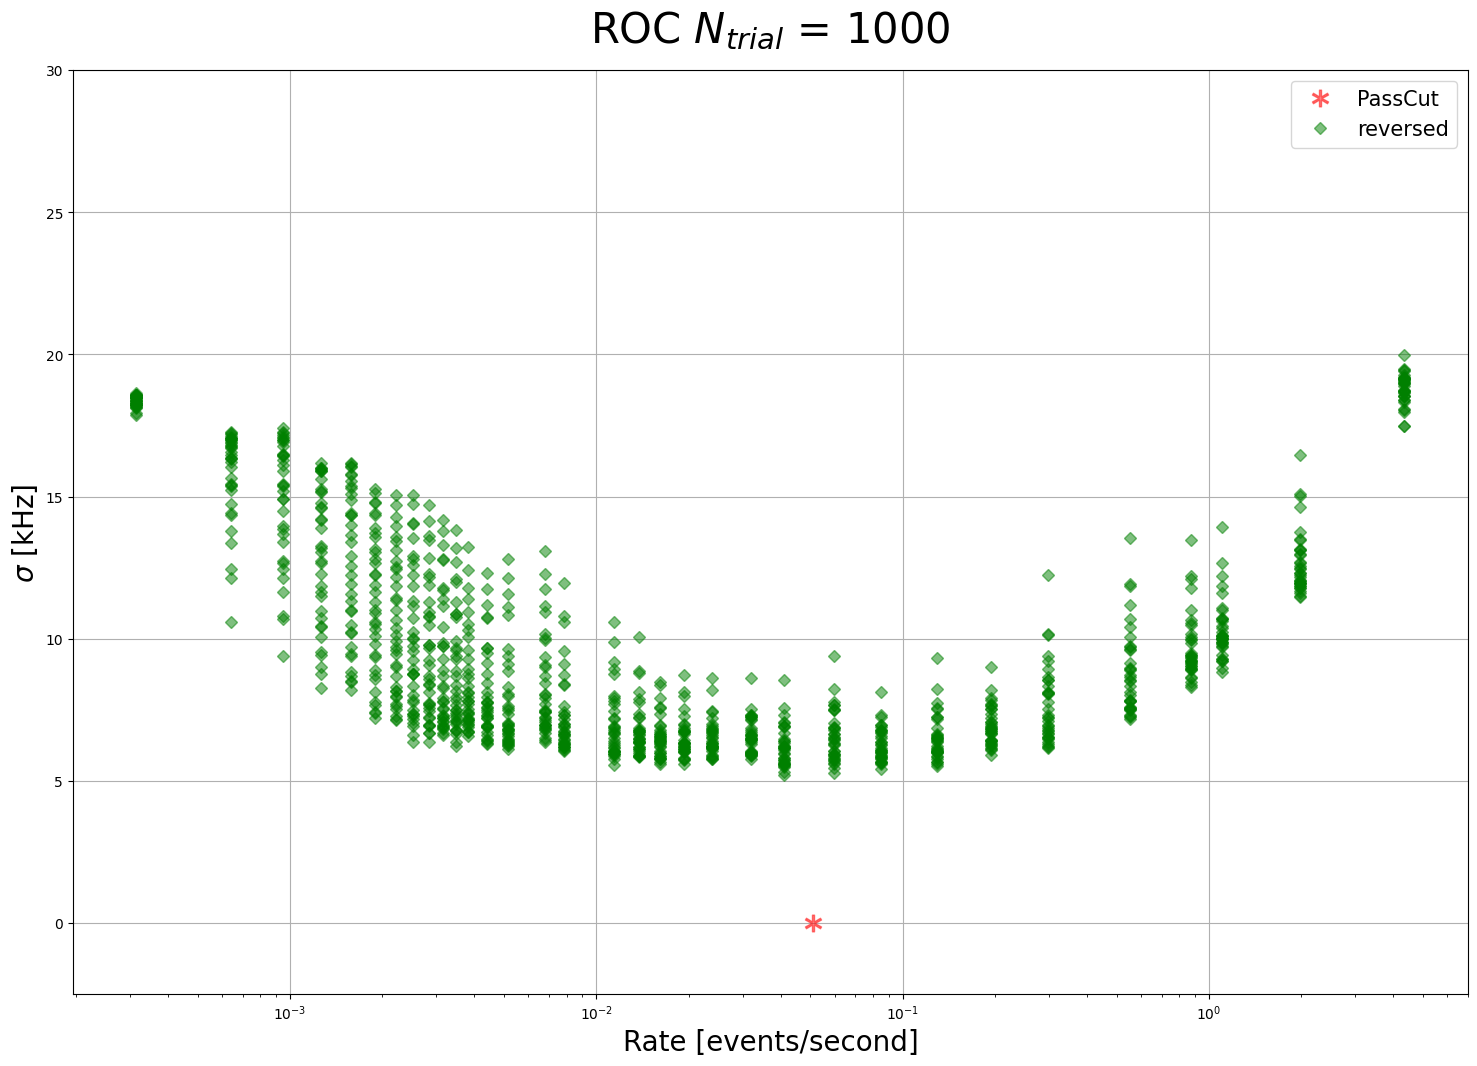

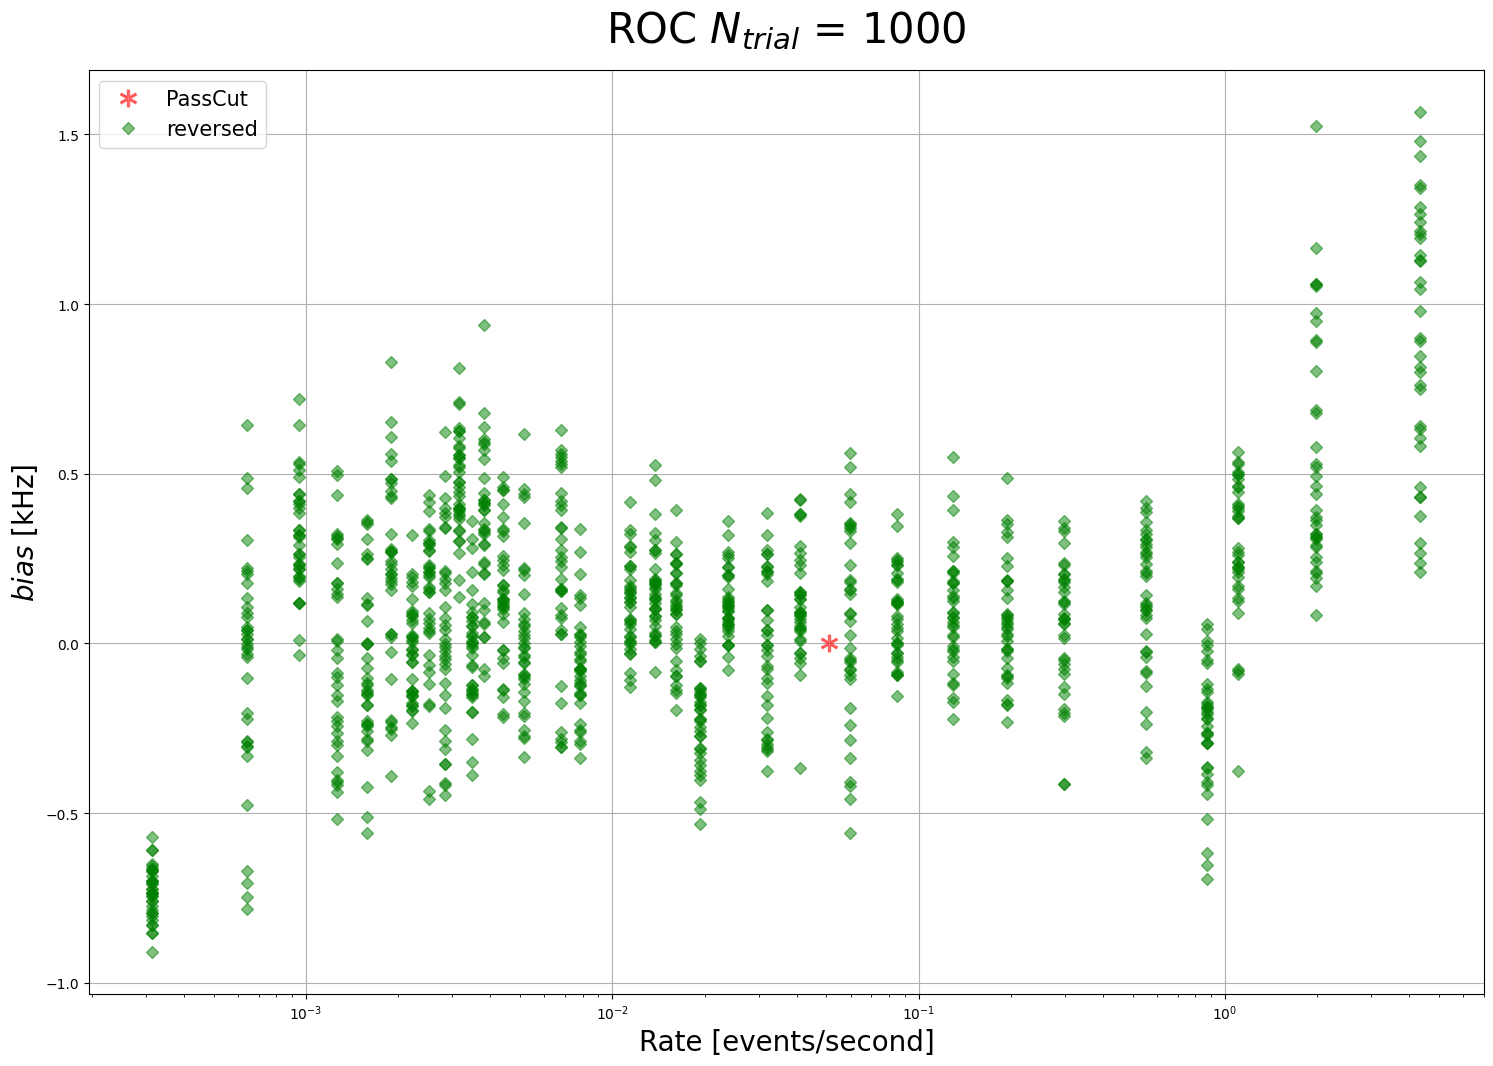

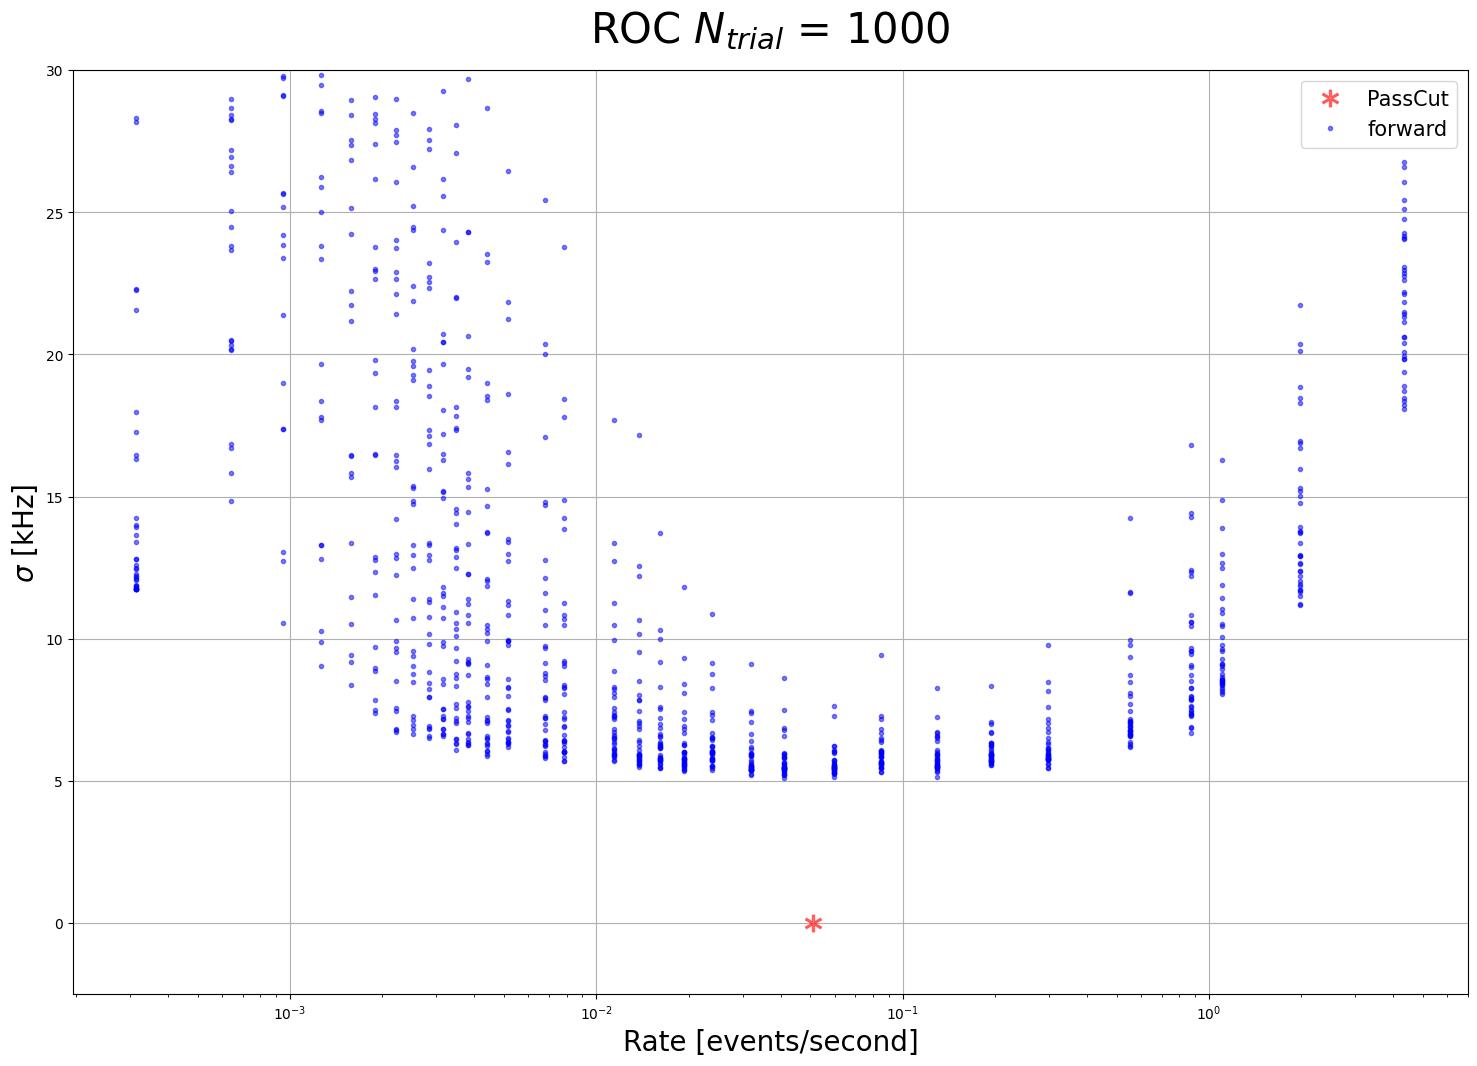

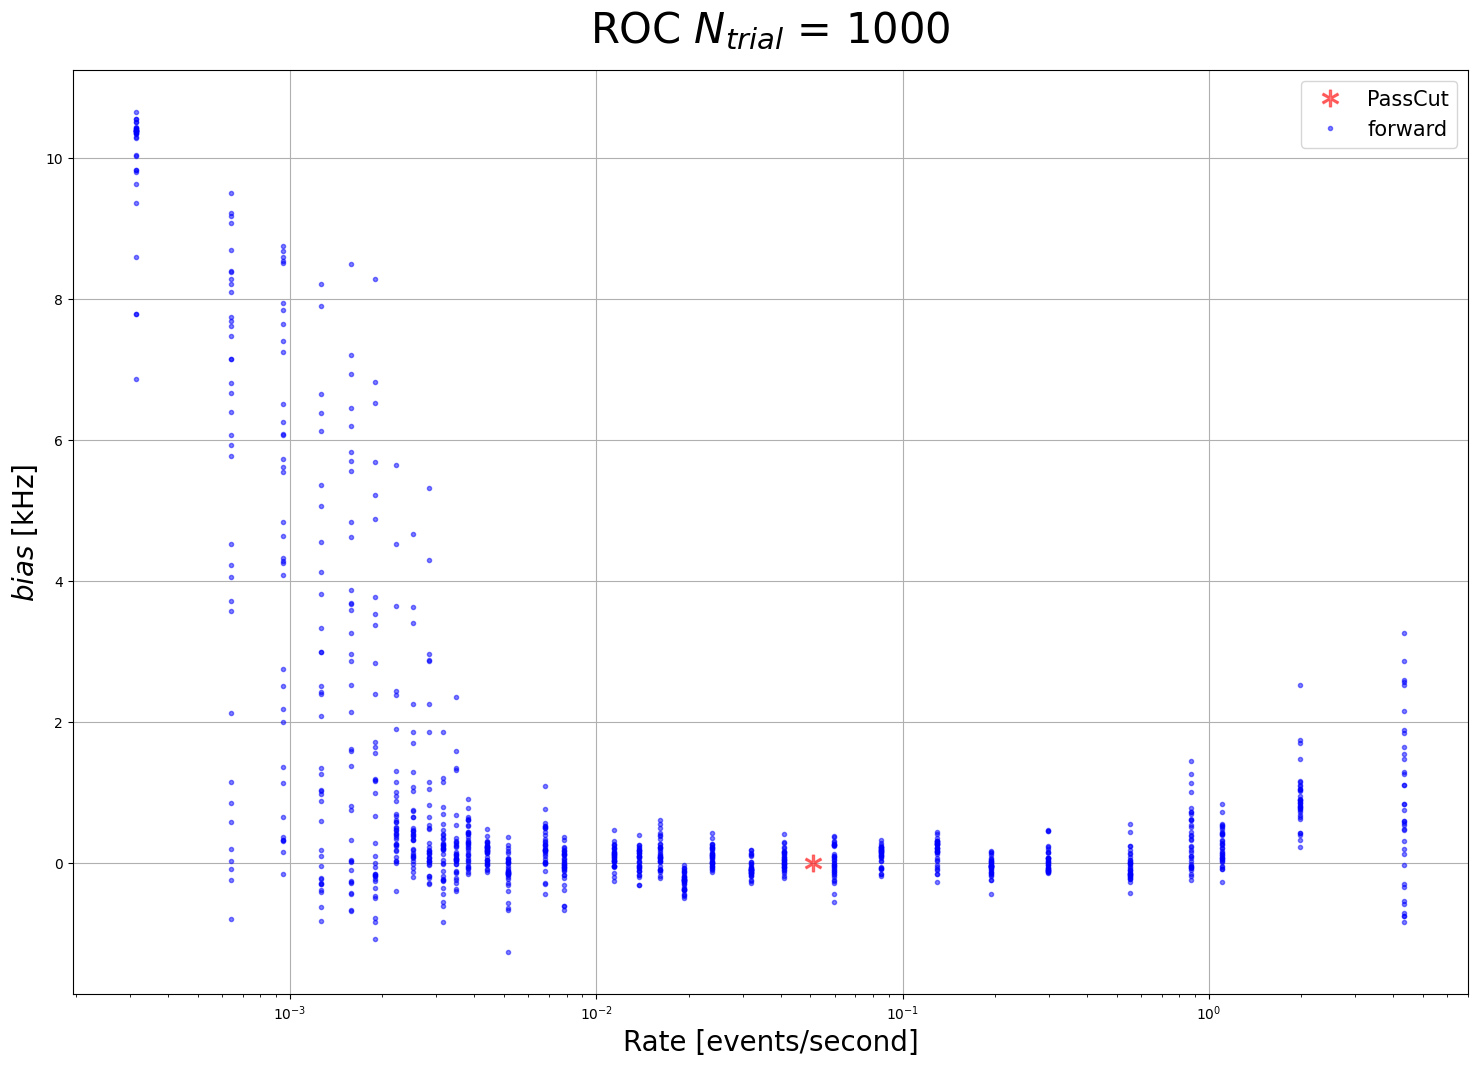

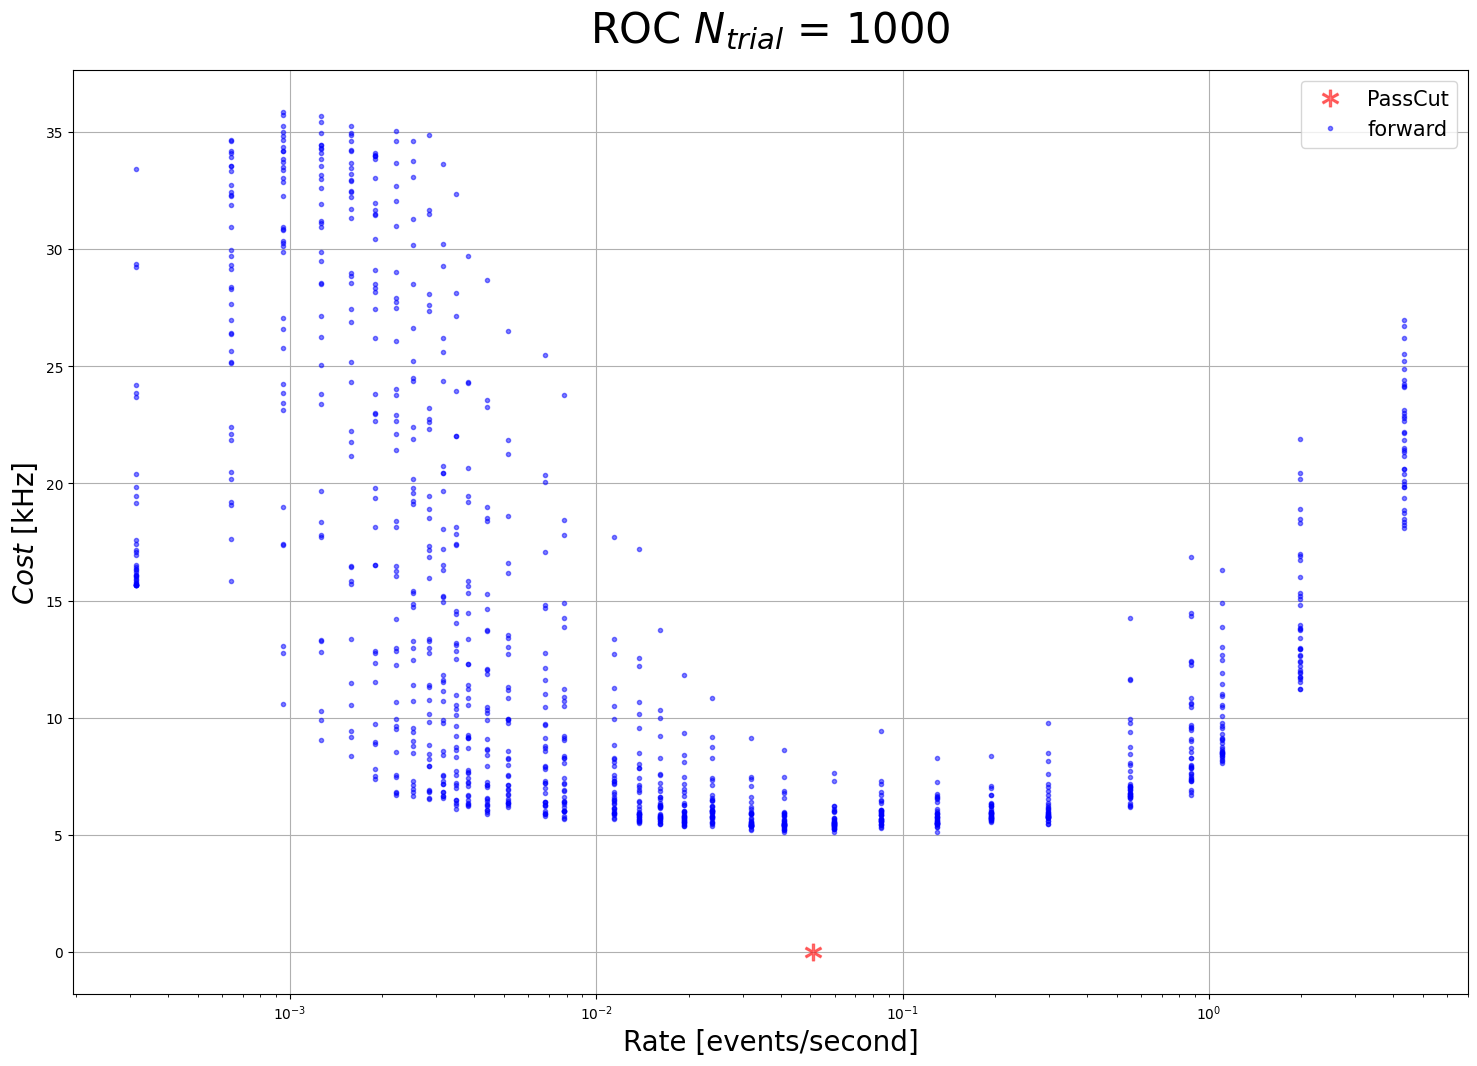

In [11]:
# SIGMA VERSUS Rate
#Rate = rate[::2]
Rate = rate
######################################################
# CONSTANT FRACTION
plt.figure(0, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$\downarrow$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 31):
        plt.errorbar(Rate, ROC_cost_cf[i], linestyle = '', marker = "v", color = "red", label = "costant fraction", alpha = 1, linewidth = 1.5)
    else:
        plt.errorbar(Rate, ROC_cost_cf[i], linestyle = '', marker = "v", color = "red",   alpha = 0.5)

plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_constantFraction_cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_constantFraction_cost.pdf", format = "pdf")

plt.figure(1, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 15):
        plt.errorbar(Rate, ROC_stdCf[i], linestyle = '', marker = "v", color = "red", label = "costant fraction", alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdVeto[i], linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdRev[i], linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdThr[i], linestyle = '',marker = "d", color = "orange", label = "over Threshold", alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdSum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_stdCf[i], linestyle = '', marker = "v", color = "red",   alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdVeto[i], linestyle = '',marker = ".", color = "blue",  markersize = 10, alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdRev[i], linestyle = '',marker = "D", color = "green",  alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdThr[i], linestyle = '',marker = "d", color = "orange", alpha = 0.5)
        #plt.errorbar(Rate, ROC_stdSum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
#plt.savefig("Plot/mvaScan/ROCsum_sigma.jpg", format = "jpg")
#plt.savefig("Plot/mvaScan/ROCsum_sigma.pdf", format = "pdf")
plt.savefig("Plot/mvaScan/ROC_constantFraction_sigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_constantFraction_sigma.pdf", format = "pdf")

# BIAS VERSUS Rate
plt.figure(2, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$bias$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        plt.errorbar(Rate, ROC_biasCf[i], linestyle = '', marker = "v", color = "red", label = "costant fraction", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasRev[i], linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "orange", label = "over Threshold", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_biasCf[i], linestyle = '', marker = "v", color = "red",   alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue",  markersize = 10, alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasRev[i], linestyle = '',marker = "D", color = "green",  alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "orange", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
#plt.savefig("Plot/mvaScan/ROC_sum_bias.jpg", format = "jpg")
#plt.savefig("Plot/mvaScan/ROC_sum_bias.pdf", format = "pdf")
plt.savefig("Plot/mvaScan/ROC_constantFraction_bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_constantFraction_bias.pdf", format = "pdf")

######################################################
# THRESHOLD

plt.figure(12321, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 2):
        plt.errorbar(Rate, ROC_cost_thr[i], linestyle = '',marker = "d", color = "purple", label = "over Threshold", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_cost_thr[i], linestyle = '',marker = "d", color = "purple", alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_singleThreshold_cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_singleThreshold_cost.pdf", format = "pdf")


plt.figure(3, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 2):
        plt.errorbar(Rate, ROC_stdThr[i], linestyle = '',marker = "d", color = "purple", label = "over Threshold", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_stdThr[i], linestyle = '',marker = "d", color = "purple", alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_singleThreshold_sigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_singleThreshold_sigma.pdf", format = "pdf")

# BIAS VERSUS Rate
plt.figure(4, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$bias$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "purple", label = "over Threshold", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "purple", alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_singleThreshold_bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_singleThreshold_bias.pdf", format = "pdf")

######################################################
# T STUDENT TEST

plt.figure(24234234, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 15):
        plt.errorbar(Rate, ROC_cost_sum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_cost_sum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROCsum_cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROCsum_cost.pdf", format = "pdf")


plt.figure(5, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 15):
        plt.errorbar(Rate, ROC_stdSum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_stdSum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROCsum_sigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROCsum_sigma.pdf", format = "pdf")

# BIAS VERSUS Rate
plt.figure(6, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$bias$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()

plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_sum_bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_sum_bias.pdf", format = "pdf")

######################################################
# REVERSED

plt.figure(242341, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
plt.ylim(-2.5,30)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 1):
        plt.errorbar(Rate, ROC_cost_rev[i], linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_cost_rev[i], linestyle = '',marker = "D", color = "green",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_reversed_cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_reversed_cost.pdf", format = "pdf")


plt.figure(7, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
plt.ylim(-2.5,30)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 1):
        plt.errorbar(Rate, ROC_stdRev[i], linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_stdRev[i], linestyle = '',marker = "D", color = "green",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_reversed_sigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_reversed_sigma.pdf", format = "pdf")

# BIAS VERSUS Rate
plt.figure(8, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$bias$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        #plt.errorbar(Rate, ROC_biasCf[i], linestyle = '', marker = "v", color = "red", label = "costant fraction", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.5)
        plt.errorbar(Rate, ROC_biasRev[i], linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "orange", label = "over Threshold", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black", label = r"t-Student test", alpha = 0.5)
    else:
        #plt.errorbar(Rate, ROC_biasCf[i], linestyle = '', marker = "v", color = "red",   alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue",  markersize = 10, alpha = 0.5)
        plt.errorbar(Rate, ROC_biasRev[i], linestyle = '',marker = "D", color = "green",  alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasThr[i], linestyle = '',marker = "d", color = "orange", alpha = 0.5)
        #plt.errorbar(Rate, ROC_biasSum[i], linestyle = '',marker = "s", color = "black",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_reversed_bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_reversed_bias.pdf", format = "pdf")

######################################################
# FOWARD (VETO)

plt.figure(9, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
plt.ylim(-2.5,30)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        plt.errorbar(Rate, ROC_stdVeto[i], linestyle = '',marker = ".", color = "blue", label = "forward", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_stdVeto[i], linestyle = '',marker = ".", color = "blue",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_foward_sigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_foward_sigma.pdf", format = "pdf")

# BIAS VERSUS Rate
plt.figure(10, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$bias$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 0):
        plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue", label = "forward", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_biasVeto[i], linestyle = '',marker = ".", color = "blue",  alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_foward_bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_foward_bias.pdf", format = "pdf")

# Coswt function
plt.figure(25234, figsize = (18,12))
plt.title("ROC " + r"$N_{trial}$ = " + str(Ntrial) , fontsize = 30)
plt.xlabel("Rate [events/second]", fontsize = 20)
plt.ylabel(r"$Cost$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.5)

for i in range(0, len(combinations)):
    if(i == 15):
        plt.errorbar(Rate, ROC_cost_veto[i], linestyle = '',marker = ".", color = "blue", label = "forward", alpha = 0.5)
    else:
        plt.errorbar(Rate, ROC_cost_veto[i], linestyle = '',marker = ".", color = "blue", alpha = 0.5)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/ROC_forward_cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/ROC_forward_cost.pdf", format = "pdf")



## THRESHOLD VERSUS BACKGROUND

constant fraction:  (26, 20)
combination: [5, 1.5, 0.25, 4, 7, 5]
t student:  (32, 22)
combination: [6, 1.5, 0.25, 4, 8, 5]
Reversed:  (32, 22)
combination: [6, 1.5, 0.25, 4, 8, 5]
Threshold:  (5, 21)
combination: [1, 3, 0.4, 7, 3, 8]
Threshold:  (10, 22)
combination: [2, 2.5, 0.35, 6, 4, 7]
combination sum: 6 3


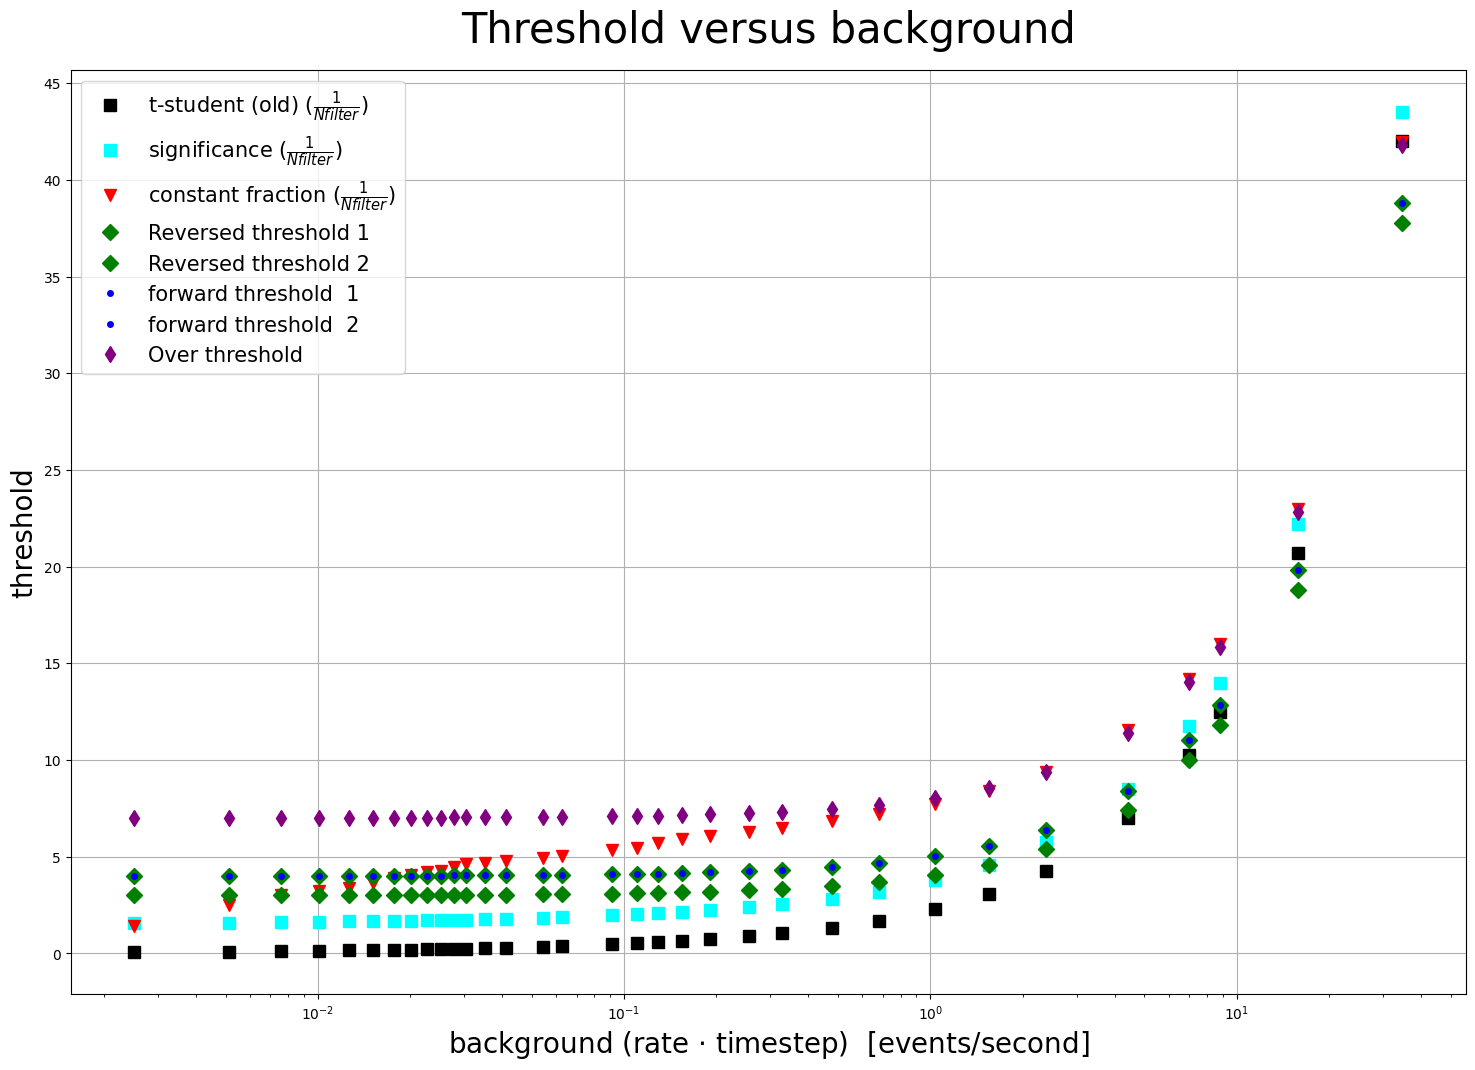

In [17]:
timestep = 8
background = rate*timestep

ind_cf = np.unravel_index(np.argmin(ROC_cost_cf, axis = None), ROC_cost_cf.shape)
print("constant fraction: ", ind_cf)
print("combination:", combinations[ind_cf[0]])

ind_sum = np.unravel_index(np.argmin(ROC_cost_sum, axis = None), ROC_cost_sum.shape)
print("t student: ", ind)
print("combination:", combinations[ind[0]])

ind = np.unravel_index(np.argmin(ROC_cost_rev, axis = None), ROC_cost_rev.shape)
print("Reversed: ", ind)
print("combination:", combinations[ind[0]])

ind_thr = np.unravel_index(np.argmin(ROC_cost_thr, axis = None), ROC_cost_thr.shape)
print("Threshold: ", ind_thr)
print("combination:", combinations[ind_thr[0]])

ind_veto = np.unravel_index(np.argmin(ROC_cost_veto, axis = None), ROC_cost_veto.shape)
print("Threshold: ", ind_veto)
print("combination:", combinations[ind_veto[0]])

# t-student
Nfilter = combinations[ind_sum[0]][0]
Nsigma = combinations[ind_sum[0]][1]
print("combination sum:" , Nfilter, Nsigma)
thr_sum = Nfilter*(background) + Nsigma*np.sqrt(Nfilter*background)
Nfilter_sum = Nfilter

# Significance 
#Nfilter*(background)
thr_sum2 = Nfilter*(background) + Nsigma**2  + Nsigma*np.sqrt(Nfilter*background)

# reversed
thr_veto1 = background + combinations[ind_veto[0]][4]
thr_veto2 = background + combinations[ind_veto[0]][5]

# reversed
thr_rev1 = background + combinations[6][4]
thr_rev2 = background + combinations[6][5]

# Threshold
thr_thr = background + combinations[ind_thr[0]][3]

# Constant fraction
Nfilter = combinations[ind_cf[0]][0]
fraction = combinations[ind_cf[1]][2]
Nhbar = 20.58; Nstack = 20
peak = 0.078*Nhbar*Nstack*efficiency + background
thr_cf = Nfilter*(background + (peak - background)*fraction)
Nfilter_cf = Nfilter

plt.figure(5234421412, figsize = (18,12))
plt.title("Threshold versus background", fontsize = 30)
plt.xscale('log')
plt.xlabel(r"background (rate $\cdot$ timestep)  [events/second]", fontsize = 20)
plt.ylabel("threshold", fontsize = 20)
plt.yticks(np.linspace(0,50,11))
plt.grid()
plt.errorbar(background, thr_sum/Nfilter_sum, linestyle = '', marker = 's', color = 'black', label = r"t-student (old) ($\frac{1}{Nfilter}$)" ,markersize = 8)
plt.errorbar(background, thr_sum2/Nfilter_sum, linestyle = '', marker = 's', color = 'cyan', label = r"significance ($\frac{1}{Nfilter}$)" ,markersize = 8)
plt.errorbar(background, thr_cf/Nfilter_cf, linestyle = '', marker = 'v', color = 'red', label = r"constant fraction ($\frac{1}{Nfilter}$)" ,markersize = 8)
plt.errorbar(background, thr_rev1, linestyle = '', marker = 'D', color = 'green', label = "Reversed threshold 1" ,markersize = 8)
plt.errorbar(background, thr_rev2, linestyle = '', marker = 'D', color = 'green', label = "Reversed threshold 2" ,markersize = 8)
plt.errorbar(background, thr_veto1, linestyle = '', marker = '.', color = 'blue', label = "forward threshold  1" ,markersize = 8)
plt.errorbar(background, thr_veto2, linestyle = '', marker = '.', color = 'blue', label = "forward threshold  2" ,markersize = 8)
plt.errorbar(background, thr_thr, linestyle = '', marker = 'd', color = 'purple', label = "Over threshold" ,markersize = 8)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/Thresholds_vs_rate.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/Thresholds_vs_rate.pdf", format = "pdf")

# SCAN OF THE MVA POINTS, NO PARAMETER OPTIMIZATION

In [ ]:
ROOT.gInterpreter.ProcessLine(".L ScanAnalysis.cpp")

In [ ]:
# Threshold
bias_thr = np.array([])
devStandard_thr = np.array([])
onset_thr = np.array([])
onset2_thr = np.array([])
bias_thr_bk = np.array([])
devStandard_thr_bk = np.array([])
onset_thr_bk = np.array([])
onset2_thr_bk = np.array([])
# Constant Fraction
bias_cf = np.array([])
devStandard_cf = np.array([])
onset_cf = np.array([])
onset2_cf = np.array([])
bias_classic = np.array([])
devStandard_classic = np.array([])
onset_classic = np.array([])
onset2_classic = np.array([])
# forward 2017
bias_fw = np.array([])
devStandard_fw = np.array([])
onset_fw = np.array([])
onset2_fw = np.array([])
bias_fw_bk = np.array([])
devStandard_fw_bk = np.array([])
onset_fw_bk = np.array([])
onset2_fw_bk = np.array([])
# Reversed 2017
bias_rev = np.array([])
devStandard_rev = np.array([])
onset_rev = np.array([])
onset2_rev = np.array([])
bias_rev_bk = np.array([])
devStandard_rev_bk = np.array([])
onset_rev_bk = np.array([])
onset2_rev_bk = np.array([])

# Sum Neighbors 
bias_sum = np.array([])
devStandard_sum = np.array([])
onset_sum = np.array([])
onset2_sum = np.array([])
# Running Difference
bias_runningDiff = np.array([])
devStandard_runningDiff = np.array([])
onset_runningDiff = np.array([])
onset2_runningDiff = np.array([])
# Hybrid method
bias_hybrid = np.array([])
devStandard_hybrid = np.array([])
onset_hybrid = np.array([])
onset2_hybrid = np.array([])

# DATA ANALYSIS

for i in range(0, len(rate)):
    folder2 = "Plot/mva_" + str(i)
    if not os.path.exists(folder2):	# Check if the folder exist
        os.makedirs(folder2)	# Create the folder

def task(i):
	values = ROOT.ScanAnalysis(folder + str(i) + "/", folder +  str(i) + "/ToyConfiguration.txt",trial, Nfilter, fraction, Nsigma, Nthr, Nthr1, Nthr2, rate[i], "Plot/mva_" + str(i) + "/")
	npResult = np.asarray(values)
	return npResult

if __name__ == "__main__":
    index = range(0,len(rate)) # index of the MVA scan
    # create the process pool
    with Pool(processes = 3, maxtasksperchild = 1) as pool:
        for results in pool.map(task, index):
            bias_thr =     np.append(bias_thr, results[0]);         devStandard_thr = np.append(devStandard_thr, results[1])
            bias_thr_bk =  np.append(bias_thr_bk, results[2]);   devStandard_thr_bk = np.append(devStandard_thr_bk, results[3])
            bias_fw =      np.append(bias_fw, results[4]);          devStandard_fw = np.append(devStandard_fw, results[5])
            bias_fw_bk =   np.append(bias_fw_bk, results[6]);    devStandard_fw_bk = np.append(devStandard_fw_bk, results[7])
            bias_rev =     np.append (bias_rev, results[8]);        devStandard_rev = np.append(devStandard_rev, results[9])
            bias_rev_bk =  np.append (bias_rev_bk, results[10]); devStandard_rev_bk = np.append(devStandard_rev_bk, results[11])
            bias_classic = np.append(bias_classic,results[12]);     devStandard_classic = np.append(devStandard_classic, results[13])
            bias_cf =      np.append (bias_cf, results[14]);        devStandard_cf = np.append(devStandard_cf, results[15])
            bias_sum =     np.append(bias_sum, results[16]);        devStandard_sum = np.append(devStandard_sum, results[17])
            onset_thr = np.append(onset_thr,results[18]);          onset_thr_bk = np.append(onset_thr_bk,results[19])
            onset_fw = np.append(onset_fw,results[20]);            onset_fw_bk = np.append(onset_fw_bk,results[21])
            onset_rev = np.append(onset_rev,results[22]);          onset_rev_bk = np.append(onset_rev_bk,results[23])
            onset_classic = np.append(onset_classic,results[24]);  onset_cf = np.append(onset_cf,results[25])
            onset_sum = np.append(onset_sum,results[26]);
            
            onset2_thr = np.append(onset2_thr,results[27]);         onset2_thr_bk = np.append(onset2_thr_bk,results[28])
            onset2_fw = np.append(onset2_fw,results[29]);           onset2_fw_bk = np.append(onset2_fw_bk,results[30])
            onset2_rev = np.append(onset2_rev,results[31]);         onset2_rev_bk = np.append(onset2_rev_bk,results[32])
            onset2_classic = np.append(onset2_classic,results[33]); onset2_cf = np.append(onset2_cf,results[34])
            onset2_sum = np.append(onset2_sum,results[35]);
            bias_runningDiff =  np.append(bias_runningDiff,results[36]);      devStandard_runningDiff = np.append(devStandard_runningDiff,results[37])
        

# PLOT THE DATA

In [ ]:
# define a cost function, function of bias and devStandard
def cost(bias,dev):
    # funzione costo : (deviazione standard + bias)**2/deviazione standard
    return np.sqrt((dev**2 + np.abs(bias)**2))

cost_cf = cost(bias_cf,devStandard_cf)	
cost_fw = cost(bias_fw,devStandard_fw)
cost_rev = cost(bias_rev,devStandard_rev)
cost_sum = cost(bias_sum,devStandard_sum)
cost_thr = cost(bias_thr,devStandard_thr)
cost_classic = cost(bias_classic,devStandard_classic)

plt.figure(0, figsize = (18,12))
plt.title("MVA curve", fontsize = 30)
plt.xscale('log')
plt.xlabel("rate [events/second]", fontsize = 20)
plt.ylabel("efficiency", fontsize = 20)
plt.grid()
plt.errorbar(rate, efficiency, linestyle = '', marker = '.', color = 'red', markersize = 12)

plt.figure(1, figsize = (18,12))
plt.title("MVA scan " + r"$N_{trial}$ = " + str(trial + 1) , fontsize = 30)
plt.xlabel("rate [events/second]", fontsize = 15)
plt.ylabel("cost [kHz]", fontsize = 15)
plt.xscale("log")
plt.ylim(0,20)
plt.grid()
#plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$\downarrow$', markersize = 12, label = "PassCut", alpha = 0.75)
#plt.errorbar(rate,cost_cf, linestyle = '',marker = "v", color = "red", label = "constant fraction %.1f " % fraction, alpha = 0.75)
#plt.errorbar(rate, cost_classic, linestyle = '', marker = "v", color = "grey", label = "costant fraction %.1f (without cosmic)" % fraction, alpha = 0.75)
plt.errorbar(rate,cost_fw, linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(rate,cost_rev, linestyle = '',marker = "D", color = "green", label = "reversed", markersize = 8,alpha = 0.75)
#plt.errorbar(rate,cost_sum, linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
#plt.errorbar(rate,cost_thr, linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/cost.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/cost.pdf", format = "pdf")

# SIGMA VERSUS RATE
plt.figure(2, figsize = (18,12))
plt.title("MVA scan " + r"$N_{trial}$ = " + str(trial + 1) , fontsize = 30)
plt.xlabel("rate [events/second]", fontsize = 20)
plt.ylabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.xscale("log")
plt.grid()
#plt.yticks(np.linspace(0,45,19))
#plt.yticks(np.linspace(-5,40,19))
#plt.ylim(0,20)
#plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.75)

#plt.errorbar(rate,devStandard_cf, linestyle = '',marker = "v", color = "red", label = "constant fraction %.1f " % fraction, alpha = 0.75)
#plt.errorbar(rate,devStandard_fw_bk, linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 8, alpha = 0.75)
#plt.errorbar(rate, devStandard_rev_bk, linestyle = '',marker = "D", color = "green", label = "reversed", markersize = 8 ,alpha = 0.75)
#plt.errorbar(rate, devStandard_thr_bk, linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)

#plt.errorbar(rate, devStandard_classic, linestyle = '', marker = "v", color = "grey", label = "costant fraction %.1f (without cosmic)" % fraction, alpha = 0.75)
plt.errorbar(rate,devStandard_fw, linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(rate, devStandard_rev, linestyle = '',marker = "D", color = "green", label = "reversed", alpha = 0.75)
#plt.errorbar(rate, devStandard_thr, linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)
#plt.errorbar(rate,devStandard_sum, linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
plt.errorbar(rate,devStandard_runningDiff, linestyle = '',marker = "H", color = "brown", label = r"running difference")

plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/sigmaVSrate.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/sigmaVSrate.pdf", format = "pdf")

# BIAS HYPERFINE SPLITTING MEASUREMENT
plt.figure(3, figsize = (18,12))
plt.title(r"Bias $(onset_{da} - onset_{cb}) - MC_{truth}$  ", fontsize = 30)
plt.xlabel("rate [events/second]", fontsize = 20)
plt.ylabel("Bias [kHz]", fontsize = 20)
plt.xscale("log")
plt.ylim(-2,13)
plt.grid()
#plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.75)
#plt.errorbar(rate,np.abs(bias_cf), linestyle = '',marker = "v", color = "red", label = "constant fraction %.1f" % fraction, alpha = 0.75)
plt.errorbar(rate,np.abs(bias_fw), linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(rate,np.abs(bias_rev), linestyle = '',marker = "D", color = "green", label = "reversed", markersize = 8 ,alpha = 0.75)
#plt.errorbar(rate,np.abs(bias_sum), linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
#plt.errorbar(rate,np.abs(bias_thr), linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)

plt.errorbar(rate,np.abs(bias_runningDiff), linestyle = '',marker = "H", color = "brown", label = r"running difference")
plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/bias.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/bias.pdf", format = "pdf")
print(np.abs(bias_fw))

#BIAS ONSET C TO B
plt.figure(4, figsize = (18,12))
plt.title("Bias onset (c to b) " + r"$N_{trial}$ = " + str(trial + 1) , fontsize = 30)
plt.xlabel("rate [events/second]", fontsize = 20)
plt.ylabel("Bias onset (c to b) [kHz]", fontsize = 20)
plt.xscale("log")
plt.ylim(-25,70)
plt.grid()
#plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.75)
#plt.errorbar(rate,onset_cf, linestyle = '',marker = "v", color = "red", label = "constant fraction %.1f" % fraction, alpha = 0.75)
#plt.errorbar(rate, onset_classic, linestyle = '', marker = "v", color = "grey", label = "costant fraction %.1f (without cosmic)" % fraction, alpha = 0.75)
plt.errorbar(rate,onset_fw, linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(rate,onset_rev, linestyle = '',marker = "D", color = "green", label = "reversed", markersize = 8 ,alpha = 0.75)
#plt.errorbar(rate,onset_sum, linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
#plt.errorbar(rate,onset_thr, linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)

plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/onsetBias_cb.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/onsetBias_cb.pdf", format = "pdf")

#BIAS ONSET D TO A
plt.figure(5, figsize = (18,12))
plt.title("Bias onset (d to a) " + r"$N_{trial}$ = " + str(trial + 1) , fontsize = 30)
plt.xlabel("rate [events/second]", fontsize = 20)
plt.ylabel("Bias onset (d to a) [kHz]", fontsize = 20)
plt.xscale("log")
plt.ylim(-25,70)
plt.grid()
#plt.plot(0.051, 0, color = "red", linestyle = '', marker=r'$*$', markersize = 12, label = "PassCut", alpha = 0.75)
#plt.errorbar(rate,onset2_cf, linestyle = '',marker = "v", color = "red", label = "constant fraction %.1f" % fraction, alpha = 0.75)
#plt.errorbar(rate, onset2_classic, linestyle = '', marker = "v", color = "grey", label = "costant fraction %.1f (without cosmic)" % fraction, alpha = 0.75)
plt.errorbar(rate,onset2_fw, linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(rate,onset2_rev, linestyle = '',marker = "D", color = "green", label = "reversed", markersize = 8 ,alpha = 0.75)
#plt.errorbar(rate,onset2_sum, linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
#plt.errorbar(rate,onset2_thr, linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)

plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/onsetBias_da.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/onsetBias_da.pdf", format = "pdf")

plt.figure(6, figsize = (18,12))
plt.title(r"$\sigma$ vs Bias " + r"$N_{trial}$ = " + str(trial + 1) , fontsize = 30)
plt.xlabel(r"$\sigma$ [kHz]", fontsize = 20)
plt.ylabel("Bias [kHz]", fontsize = 20)
plt.grid()
plt.xlim(2.5,15)
plt.ylim(-0.5,4)
#plt.errorbar(devStandard_cf,np.abs(bias_cf), linestyle = '',marker = "v", color = "red", label = "constant fraction %f" % fraction, alpha = 0.75)
plt.errorbar(devStandard_fw,np.abs(bias_fw), linestyle = '',marker = ".", color = "blue", label = "forward", markersize = 10, alpha = 0.75)
plt.errorbar(devStandard_rev,np.abs(bias_rev), linestyle = '',marker = "D", color = "green", label = "reversed",markersize = 8, alpha = 0.75)
#plt.errorbar(devStandard_sum,np.abs(bias_sum), linestyle = '',marker = "s", color = "black", label = r"Neighbors sum ( > %d$\sigma$)" % Nsigma, alpha = 0.75)
#plt.errorbar(devStandard_thr,np.abs(bias_thr), linestyle = '',marker = "d", color = "orange", label = "over Threshold (> 3)", alpha = 0.75)

plt.legend(fontsize = 15)
plt.savefig("Plot/mvaScan/biasVSsigma.jpg", format = "jpg")
plt.savefig("Plot/mvaScan/biasVSsigma.pdf", format = "pdf")
plt.show()
